In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Reusable Functions

In [24]:
def explore_dataframe(df, title="DATAFRAME EXPLORATION", date_col=None, max_cols_for_plots=1000):
    """
    Comprehensive data exploration function for any pandas DataFrame
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to explore
    title : str
        Title for the exploration report
    date_col : str, optional
        Name of the date column (if exists) for time series analysis
    max_cols_for_plots : int
        Maximum number of columns to include in detailed plots
    
    Returns:
    --------
    dict : Summary statistics and insights
    """
    print(title.upper())
    print("=" * len(title))
    
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Data types:\n{df.dtypes.value_counts()}")
    
    # Date range if date column exists
    if date_col and date_col in df.columns:
        try:
            date_series = pd.to_datetime(df[date_col])
            print(f"Date range: {date_series.min()} to {date_series.max()}")
        except:
            print(f"Could not parse {date_col} as date")
    
    # Get numeric columns for analysis
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if date_col and date_col in numeric_cols:
        numeric_cols.remove(date_col)
    
    if not numeric_cols:
        print("No numeric columns found for analysis")
        return {}
    
    numeric_data = df[numeric_cols]
    
    # Missing values analysis
    missing_total = df.isnull().sum().sum()
    print(f"Missing values: {missing_total} ({(missing_total/(df.shape[0]*df.shape[1]))*100:.1f}%)")
    
    if missing_total > 0:
        missing_by_col = df.isnull().sum()
        worst_cols = missing_by_col[missing_by_col > 0].head(3)
        print("Worst columns for missing data:")
        for col, missing in worst_cols.items():
            print(f"  {col}: {missing} ({(missing/len(df))*100:.1f}%)")
    
    # Basic statistics
    print(f"\nKey Statistics:")
    all_data = numeric_data.values.flatten()
    all_data_clean = all_data[~np.isnan(all_data)]
    
    if len(all_data_clean) > 0:
        print(f"Overall mean: {np.mean(all_data_clean):.6f}")
        print(f"Overall min: {np.min(all_data_clean):.6f}")
        print(f"Overall max: {np.max(all_data_clean):.6f}")
        print(f"Overall std: {np.std(all_data_clean):.6f}")
        
        # Sign analysis
        positive_pct = (all_data_clean > 0).mean() * 100
        negative_pct = (all_data_clean < 0).mean() * 100
        zero_pct = (all_data_clean == 0).mean() * 100
        
        print(f"Positive values: {positive_pct:.1f}%")
        print(f"Negative values: {negative_pct:.1f}%")
        print(f"Zero values: {zero_pct:.1f}%")
    
    # Visualizations
    n_plots = min(4, len(numeric_cols) + 1)  # +1 for overall distribution
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    plot_idx = 0
    
    # Overall distribution
    if len(all_data_clean) > 0:
        axes[plot_idx].hist(all_data_clean, bins=50, alpha=0.7, edgecolor='black')
        axes[plot_idx].set_title('Overall Distribution')
        axes[plot_idx].set_xlabel('Values')
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
    
    # Box plot for outliers (limit columns to avoid clutter)
    if len(numeric_cols) <= 10:
        numeric_data.boxplot(ax=axes[plot_idx])
        axes[plot_idx].set_title('Box Plot (Outlier Detection)')
        axes[plot_idx].tick_params(axis='x', rotation=45)
    else:
        # Show only first few columns
        df[numeric_cols[:max_cols_for_plots]].boxplot(ax=axes[plot_idx])
        axes[plot_idx].set_title(f'Box Plot (First {max_cols_for_plots} columns)')
        axes[plot_idx].tick_params(axis='x', rotation=45)
    plot_idx += 1
    
    # Time series plot
    if date_col and date_col in df.columns and len(numeric_cols) > 0:
        try:
            date_series = pd.to_datetime(df[date_col])
            axes[plot_idx].plot(date_series, df[numeric_cols[0]], alpha=0.7)
            axes[plot_idx].set_title(f'{numeric_cols[0]} Over Time')
            axes[plot_idx].tick_params(axis='x', rotation=45)
            axes[plot_idx].grid(True, alpha=0.3)
        except:
            axes[plot_idx].text(0.5, 0.5, 'Time series plot failed', ha='center', va='center')
            axes[plot_idx].set_title('Time Series N/A')
    else:
        axes[plot_idx].text(0.5, 0.5, 'No date column provided', ha='center', va='center')
        axes[plot_idx].set_title('Time Series N/A')
    plot_idx += 1
    
    # Average values by column (top columns)
    if len(numeric_cols) > 0:
        top_cols = numeric_cols[:max_cols_for_plots]
        means = [df[col].mean() for col in top_cols]
        axes[plot_idx].bar(range(len(top_cols)), means)
        axes[plot_idx].set_title('Average Values by Column')
        axes[plot_idx].set_xticks(range(len(top_cols)))
        axes[plot_idx].set_xticklabels(top_cols, rotation=45)
        axes[plot_idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print(f"\n✓ All values non-negative: {'Yes' if negative_pct == 0 else 'No'}")
    print(f"✓ Total numeric columns: {len(numeric_cols)}")
    print(f"✓ Data completeness: {((df.shape[0]*df.shape[1] - missing_total)/(df.shape[0]*df.shape[1]))*100:.1f}%")
    print("=" * len(title))
    
    # Return summary dict
    return {
        'shape': df.shape,
        'numeric_columns': len(numeric_cols),
        'missing_percentage': (missing_total/(df.shape[0]*df.shape[1]))*100,
        'all_non_negative': negative_pct == 0 if len(all_data_clean) > 0 else None,
        'mean': np.mean(all_data_clean) if len(all_data_clean) > 0 else None,
        'std': np.std(all_data_clean) if len(all_data_clean) > 0 else None
    }

In [55]:
def analyze_nan_patterns(df, title="NaN PATTERN ANALYSIS", date_col=None, min_consecutive_days=30):
    """
    Comprehensive NaN pattern analysis for any pandas DataFrame
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to analyze
    title : str
        Title for the analysis report
    date_col : str, optional
        Name of the date column (if exists) for time series analysis
    min_consecutive_days : int
        Minimum consecutive NaN days to consider as a pattern
    
    Returns:
    --------
    dict : Summary of NaN patterns and statistics
    """
    print(title.upper())
    print("=" * len(title))
    
    # Basic NaN statistics
    total_cells = df.shape[0] * df.shape[1]
    total_nans = df.isnull().sum().sum()
    nan_percentage = (total_nans / total_cells) * 100
    
    print(f"Overall NaN Statistics:")
    print(f"Total cells: {total_cells:,}")
    print(f"Total NaN values: {total_nans:,}")
    print(f"Overall NaN percentage: {nan_percentage:.2f}%")
    
    # NaN by column
    nans_by_col = df.isnull().sum()
    cols_with_nans = nans_by_col[nans_by_col > 0]
    
    print(f"\nColumn-wise NaN Analysis:")
    print(f"Columns with NaN values: {len(cols_with_nans)} out of {len(df.columns)}")
    
    if len(cols_with_nans) > 0:
        print(f"Worst 5 columns for NaN values:")
        worst_cols = cols_with_nans.sort_values(ascending=False).head(5)
        for col, count in worst_cols.items():
            percentage = (count / len(df)) * 100
            print(f"  {col}: {count} NaNs ({percentage:.1f}%)")
    
    # NaN by row
    nans_by_row = df.isnull().sum(axis=1)
    rows_with_nans = nans_by_row[nans_by_row > 0]
    
    print(f"\nRow-wise NaN Analysis:")
    print(f"Rows with NaN values: {len(rows_with_nans)} out of {len(df)}")
    
    if len(rows_with_nans) > 0:
        print(f"Average NaNs per affected row: {rows_with_nans.mean():.1f}")
        print(f"Max NaNs in a single row: {rows_with_nans.max()}")
    
    # Pattern analysis (inspired by your stock analysis)
    patterns = {
        'initial_nans': {},  # Columns that start with NaNs then have data
        'final_nans': {},    # Columns that have data then end with NaNs
        'scattered_nans': {},  # Columns with scattered NaN patterns
        'complete_columns': [],  # Columns with no NaNs
        'all_nan_columns': []   # Columns that are entirely NaN
    }
    
    print(f"\nPattern Analysis:")
    
    for col in df.columns:
        col_data = df[col]
        col_nans = col_data.isnull().sum()
        
        if col_nans == 0:
            patterns['complete_columns'].append(col)
        elif col_nans == len(df):
            patterns['all_nan_columns'].append(col)
        else:
            # Find first and last valid indices
            first_valid = col_data.first_valid_index()
            last_valid = col_data.last_valid_index()
            
            if first_valid is not None and last_valid is not None:
                # Initial NaNs pattern
                if first_valid != df.index[0]:  # Not starting from first row
                    try:
                        first_idx_pos = df.index.get_loc(first_valid)
                        if first_idx_pos >= min_consecutive_days:
                            patterns['initial_nans'][col] = {
                                'first_valid_index': first_valid,
                                'initial_nan_count': first_idx_pos,
                                'data_completeness': ((len(df) - col_nans) / len(df)) * 100
                            }
                    except:
                        pass
                
                # Final NaNs pattern
                if last_valid != df.index[-1]:  # Not ending at last row
                    try:
                        last_idx_pos = df.index.get_loc(last_valid)
                        final_nans = len(df) - last_idx_pos - 1
                        if final_nans >= min_consecutive_days:
                            patterns['final_nans'][col] = {
                                'last_valid_index': last_valid,
                                'final_nan_count': final_nans,
                                'data_completeness': ((len(df) - col_nans) / len(df)) * 100
                            }
                    except:
                        pass
                
                # Check for scattered pattern (NaNs in middle)
                if col not in patterns['initial_nans'] and col not in patterns['final_nans']:
                    # Check if there are NaNs between first and last valid
                    middle_data = col_data.loc[first_valid:last_valid]
                    middle_nans = middle_data.isnull().sum()
                    if middle_nans > 0:
                        patterns['scattered_nans'][col] = {
                            'scattered_nan_count': middle_nans,
                            'data_range': f"{first_valid} to {last_valid}",
                            'data_completeness': ((len(df) - col_nans) / len(df)) * 100
                        }
    
    # Print pattern summary
    print(f"Complete columns (no NaNs): {len(patterns['complete_columns'])}")
    print(f"All-NaN columns: {len(patterns['all_nan_columns'])}")
    print(f"Initial NaN pattern columns: {len(patterns['initial_nans'])}")
    print(f"Final NaN pattern columns: {len(patterns['final_nans'])}")
    print(f"Scattered NaN pattern columns: {len(patterns['scattered_nans'])}")
    
    # Detailed pattern info
    if patterns['initial_nans']:
        print(f"\nInitial NaN Patterns (first {min_consecutive_days}+ rows are NaN):")
        for col, info in list(patterns['initial_nans'].items())[:3]:  # Show first 3
            print(f"  {col}: {info['initial_nan_count']} initial NaNs, {info['data_completeness']:.1f}% complete")
    
    if patterns['final_nans']:
        print(f"\nFinal NaN Patterns (last {min_consecutive_days}+ rows are NaN):")
        for col, info in list(patterns['final_nans'].items())[:3]:  # Show first 3
            print(f"  {col}: {info['final_nan_count']} final NaNs, {info['data_completeness']:.1f}% complete")
    
    if patterns['scattered_nans']:
        print(f"\nScattered NaN Patterns:")
        for col, info in list(patterns['scattered_nans'].items())[:3]:  # Show first 3
            print(f"  {col}: {info['scattered_nan_count']} scattered NaNs, {info['data_completeness']:.1f}% complete")
    
    # Visualization
    if total_nans > 0:
        print(f"\nGenerating NaN visualizations...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Overall NaN heatmap
        if df.shape[1] <= 50:  # Only if manageable number of columns
            sns.heatmap(df.isnull(), cbar=True, cmap='viridis', 
                       xticklabels=False, yticklabels=False, ax=axes[0,0])
            axes[0,0].set_title('Overall NaN Pattern')
        else:
            axes[0,0].text(0.5, 0.5, f'Too many columns ({df.shape[1]}) for heatmap', 
                          ha='center', va='center')
            axes[0,0].set_title('NaN Heatmap (Skipped)')
        
        # NaN count by column
        if len(cols_with_nans) > 0:
            top_nan_cols = cols_with_nans.sort_values(ascending=False).head(10)
            axes[0,1].bar(range(len(top_nan_cols)), top_nan_cols.values)
            axes[0,1].set_title('Top 10 Columns by NaN Count')
            axes[0,1].set_xticks(range(len(top_nan_cols)))
            axes[0,1].set_xticklabels(top_nan_cols.index, rotation=45)
            axes[0,1].grid(True, alpha=0.3)
        
        # NaN count by row (time series if date column)
        if len(rows_with_nans) > 0:
            if date_col and date_col in df.columns:
                try:
                    date_index = pd.to_datetime(df[date_col])
                    axes[1,0].plot(date_index, nans_by_row, alpha=0.7)
                    axes[1,0].set_title('NaN Count Over Time')
                    axes[1,0].tick_params(axis='x', rotation=45)
                except:
                    axes[1,0].plot(nans_by_row.values, alpha=0.7)
                    axes[1,0].set_title('NaN Count by Row Index')
            else:
                axes[1,0].plot(nans_by_row.values, alpha=0.7)
                axes[1,0].set_title('NaN Count by Row Index')
            axes[1,0].grid(True, alpha=0.3)
        
        # Pattern distribution pie chart
        pattern_counts = [
            len(patterns['complete_columns']),
            len(patterns['initial_nans']),
            len(patterns['final_nans']),
            len(patterns['scattered_nans']),
            len(patterns['all_nan_columns'])
        ]
        pattern_labels = ['Complete', 'Initial NaNs', 'Final NaNs', 'Scattered NaNs', 'All NaNs']
        
        # Only include non-zero categories
        non_zero_counts = [(count, label) for count, label in zip(pattern_counts, pattern_labels) if count > 0]
        if non_zero_counts:
            counts, labels = zip(*non_zero_counts)
            axes[1,1].pie(counts, labels=labels, autopct='%1.1f%%')
            axes[1,1].set_title('Column Pattern Distribution')
        
        plt.tight_layout()
        plt.show()
    
    print("=" * len(title))
    
    # Return summary
    return {
        'total_nans': total_nans,
        'nan_percentage': nan_percentage,
        'columns_with_nans': len(cols_with_nans),
        'rows_with_nans': len(rows_with_nans),
        'patterns': patterns,
        'worst_columns': dict(worst_cols.head(5)) if len(cols_with_nans) > 0 else {}
    }

In [80]:
def comprehensive_nan_analysis(df, title="COMPREHENSIVE NaN ANALYSIS", date_col=None, top_n_display=20):
    """
    Comprehensive NaN analysis for datasets with many columns (optimized for ~1000 columns)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to analyze
    title : str
        Title for the analysis report
    date_col : str, optional
        Name of the date column (if exists) for time series analysis
    top_n_display : int
        Number of top/worst items to display in detailed lists
    
    Returns:
    --------
    dict : Comprehensive summary of NaN patterns and statistics
    """
    print(title.upper())
    print("=" * len(title))
    
    # Basic statistics
    total_cells = df.shape[0] * df.shape[1]
    total_nans = df.isnull().sum().sum()
    nan_percentage = (total_nans / total_cells) * 100
    
    print(f"Dataset Overview:")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
    print(f"Total cells: {total_cells:,}")
    print(f"Total NaN values: {total_nans:,}")
    print(f"Overall NaN percentage: {nan_percentage:.3f}%")
    
    # =====================================
    # COLUMN-WISE ANALYSIS
    # =====================================
    print(f"\n{'='*20} COLUMN-WISE ANALYSIS {'='*20}")
    
    nans_by_col = df.isnull().sum()
    cols_with_nans = nans_by_col[nans_by_col > 0]
    cols_without_nans = nans_by_col[nans_by_col == 0]
    
    print(f"Columns with NaN values: {len(cols_with_nans):,} ({(len(cols_with_nans)/len(df.columns))*100:.1f}%)")
    print(f"Columns without NaN values: {len(cols_without_nans):,} ({(len(cols_without_nans)/len(df.columns))*100:.1f}%)")
    
    if len(cols_with_nans) > 0:
        # Column statistics
        col_nan_percentages = (nans_by_col / len(df)) * 100
        
        print(f"\nColumn NaN Statistics:")
        print(f"Mean NaNs per column: {nans_by_col.mean():.1f}")
        print(f"Median NaNs per column: {nans_by_col.median():.1f}")
        print(f"Std NaNs per column: {nans_by_col.std():.1f}")
        print(f"Max NaNs in a column: {nans_by_col.max():,} ({col_nan_percentages.max():.1f}%)")
        print(f"Min NaNs in affected columns: {cols_with_nans.min():,}")
        
        # Top worst columns
        worst_cols = cols_with_nans.sort_values(ascending=False).head(top_n_display)
        print(f"\nTop {top_n_display} worst columns for NaN values:")
        for i, (col, count) in enumerate(worst_cols.items(), 1):
            percentage = (count / len(df)) * 100
            print(f"  {i:2d}. {col}: {count:,} NaNs ({percentage:.1f}%)")
    
    # =====================================
    # ROW-WISE ANALYSIS
    # =====================================
    print(f"\n{'='*20} ROW-WISE ANALYSIS {'='*22}")
    
    nans_by_row = df.isnull().sum(axis=1)
    rows_with_nans = nans_by_row[nans_by_row > 0]
    rows_without_nans = nans_by_row[nans_by_row == 0]
    
    print(f"Rows with NaN values: {len(rows_with_nans):,} ({(len(rows_with_nans)/len(df))*100:.1f}%)")
    print(f"Rows without NaN values: {len(rows_without_nans):,} ({(len(rows_without_nans)/len(df))*100:.1f}%)")
    
    if len(rows_with_nans) > 0:
        # Row statistics
        row_nan_percentages = (nans_by_row / len(df.columns)) * 100
        
        print(f"\nRow NaN Statistics:")
        print(f"Mean NaNs per row: {nans_by_row.mean():.1f}")
        print(f"Median NaNs per row: {nans_by_row.median():.1f}")
        print(f"Std NaNs per row: {nans_by_row.std():.1f}")
        print(f"Max NaNs in a row: {nans_by_row.max():,} ({row_nan_percentages.max():.1f}%)")
        print(f"Min NaNs in affected rows: {rows_with_nans.min():,}")
        
        # Top worst rows (show index/date if available)
        worst_rows = rows_with_nans.sort_values(ascending=False).head(top_n_display)
        print(f"\nTop {top_n_display} worst rows for NaN values:")
        for i, (idx, count) in enumerate(worst_rows.items(), 1):
            percentage = (count / len(df.columns)) * 100
            print(f"  {i:2d}. Index {idx}: {count:,} NaNs ({percentage:.1f}%)")
    
    # =====================================
    # NaN RUN LENGTH ANALYSIS (for stocks/columns)
    # =====================================
    print(f"\n{'='*20} NaN RUN LENGTH ANALYSIS {'='*20}")
    
    def get_nan_runs(series):
        """Get consecutive NaN run lengths for a series"""
        if series.isnull().sum() == 0:
            return []
        
        # Convert to boolean (True = NaN)
        is_nan = series.isnull()
        
        # Find run lengths
        runs = []
        current_run = 0
        
        for val in is_nan:
            if val:  # Is NaN
                current_run += 1
            else:  # Not NaN
                if current_run > 0:
                    runs.append(current_run)
                    current_run = 0
        
        # Don't forget the last run if it ends with NaN
        if current_run > 0:
            runs.append(current_run)
            
        return runs
    
    # Analyze run lengths for all columns
    all_run_lengths = []
    column_run_stats = {}
    
    print("Calculating NaN run lengths for all columns...")
    
    for col in df.columns:
        runs = get_nan_runs(df[col])
        all_run_lengths.extend(runs)
        
        if runs:
            column_run_stats[col] = {
                'num_runs': len(runs),
                'shortest_run': min(runs),
                'longest_run': max(runs),
                'mean_run_length': np.mean(runs),
                'total_nan_days': sum(runs)
            }
    
    if all_run_lengths:
        print(f"\nOverall Run Length Statistics:")
        print(f"Total number of NaN runs: {len(all_run_lengths):,}")
        print(f"Shortest run: {min(all_run_lengths)} consecutive NaNs")
        print(f"Longest run: {max(all_run_lengths)} consecutive NaNs")
        print(f"Mean run length: {np.mean(all_run_lengths):.1f} consecutive NaNs")
        print(f"Median run length: {np.median(all_run_lengths):.1f} consecutive NaNs")
        
        # Show stocks with longest runs
        if column_run_stats:
            longest_run_stocks = sorted(column_run_stats.items(), 
                                      key=lambda x: x[1]['longest_run'], 
                                      reverse=True)[:top_n_display]
            
            print(f"\nTop {top_n_display} stocks with longest NaN runs:")
            for i, (stock, stats) in enumerate(longest_run_stocks, 1):
                print(f"  {i:2d}. {stock}: {stats['longest_run']} consecutive NaNs "
                      f"({stats['num_runs']} runs total)")
    
    # =====================================
    # VISUALIZATION SECTION
    # =====================================
    print(f"\n{'='*20} GENERATING VISUALIZATIONS {'='*20}")
    
    # Create comprehensive visualization grid
    fig = plt.figure(figsize=(24, 16))  # Very wide figure for many columns
    
    # Layout: 3 rows, 3 columns
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Column-wise NaN histogram (FULL WIDTH - spans 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    if len(cols_with_nans) > 0:
        # For many columns, use bins and don't show individual column names
        if len(df.columns) > 100:
            ax1.hist(nans_by_col, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
            ax1.set_title(f'Distribution of NaN Counts Across {len(df.columns):,} Columns')
            ax1.set_xlabel('Number of NaN Values')
            ax1.set_ylabel('Number of Columns')
        else:
            # For fewer columns, show bar plot
            nans_by_col.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.7)
            ax1.set_title('NaN Count by Column')
            ax1.set_xlabel('Columns')
            ax1.set_ylabel('Number of NaN Values')
            ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. Row-wise NaN histogram  
    ax2 = fig.add_subplot(gs[0, 2])
    if len(rows_with_nans) > 0:
        ax2.hist(nans_by_row, bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
        ax2.set_title('Distribution of NaN Counts Across Rows')
        ax2.set_xlabel('Number of NaN Values')
        ax2.set_ylabel('Number of Rows')
    ax2.grid(True, alpha=0.3)
    
    # 3. NaN run length distribution
    ax3 = fig.add_subplot(gs[1, 0])
    if all_run_lengths:
        ax3.hist(all_run_lengths, bins=min(50, len(set(all_run_lengths))), 
                alpha=0.7, edgecolor='black', color='lightgreen')
        ax3.set_title('Distribution of NaN Run Lengths')
        ax3.set_xlabel('Consecutive NaN Days')
        ax3.set_ylabel('Frequency')
        ax3.set_yscale('log')  # Log scale due to potential wide range
    ax3.grid(True, alpha=0.3)
    
    # 4. NaN percentage by column (top worst)
    ax4 = fig.add_subplot(gs[1, 1])
    if len(cols_with_nans) > 0:
        top_20_worst = cols_with_nans.sort_values(ascending=False).head(20)
        top_20_percentages = (top_20_worst / len(df)) * 100
        ax4.barh(range(len(top_20_percentages)), top_20_percentages.values, color='orange', alpha=0.7)
        ax4.set_yticks(range(len(top_20_percentages)))
        ax4.set_yticklabels(top_20_percentages.index, fontsize=8)
        ax4.set_title('Top 20 Worst Columns (% NaN)')
        ax4.set_xlabel('NaN Percentage')
    ax4.grid(True, alpha=0.3)
    
    # 5. Time series of NaN counts (if date column available)
    ax5 = fig.add_subplot(gs[1, 2])
    if date_col and date_col in df.columns:
        try:
            date_index = pd.to_datetime(df[date_col]) if date_col != df.index.name else df.index
            ax5.plot(date_index, nans_by_row, alpha=0.7, color='purple', linewidth=0.5)
            ax5.set_title('NaN Count Over Time')
            ax5.set_xlabel('Date')
            ax5.set_ylabel('NaN Count per Row')
            ax5.tick_params(axis='x', rotation=45)
        except:
            ax5.plot(nans_by_row.values, alpha=0.7, color='purple')
            ax5.set_title('NaN Count by Row Index')
            ax5.set_xlabel('Row Index')
            ax5.set_ylabel('NaN Count')
    else:
        ax5.plot(nans_by_row.values, alpha=0.7, color='purple')
        ax5.set_title('NaN Count by Row Index')
        ax5.set_xlabel('Row Index')
        ax5.set_ylabel('NaN Count')
    ax5.grid(True, alpha=0.3)
    
    # 6. Heatmap of worst columns (FULL WIDTH BOTTOM)
    ax6 = fig.add_subplot(gs[2, :])
    if len(cols_with_nans) > 0:
        # Show worst 50 columns in heatmap
        n_cols_to_show = min(50, len(cols_with_nans))
        worst_cols_for_heatmap = cols_with_nans.sort_values(ascending=False).head(n_cols_to_show).index
        
        heatmap_data = df[worst_cols_for_heatmap].isnull()
        sns.heatmap(heatmap_data.T, cbar=True, cmap='RdYlBu_r', 
                   xticklabels=False, yticklabels=True, ax=ax6)
        ax6.set_title(f'NaN Pattern Heatmap - {n_cols_to_show} Worst Columns')
        ax6.set_xlabel('Time/Rows')
        ax6.set_ylabel('Columns (Stocks)')
    
    plt.tight_layout()
    plt.show()
    
    # =====================================
    # SUMMARY STATISTICS TABLE
    # =====================================
    print(f"\n{'='*20} SUMMARY STATISTICS {'='*20}")
    
    summary_stats = {
        'dataset_shape': df.shape,
        'total_cells': total_cells,
        'total_nans': total_nans,
        'overall_nan_percentage': nan_percentage,
        'columns_with_nans': len(cols_with_nans),
        'columns_without_nans': len(cols_without_nans),
        'rows_with_nans': len(rows_with_nans),
        'rows_without_nans': len(rows_without_nans),
        'column_stats': {
            'mean_nans_per_column': nans_by_col.mean(),
            'max_nans_in_column': nans_by_col.max(),
            'worst_column': nans_by_col.idxmax() if len(cols_with_nans) > 0 else None
        },
        'row_stats': {
            'mean_nans_per_row': nans_by_row.mean(),
            'max_nans_in_row': nans_by_row.max()
        },
        'run_length_stats': {
            'total_runs': len(all_run_lengths),
            'shortest_run': min(all_run_lengths) if all_run_lengths else 0,
            'longest_run': max(all_run_lengths) if all_run_lengths else 0,
            'mean_run_length': np.mean(all_run_lengths) if all_run_lengths else 0
        },
        'column_run_stats': column_run_stats
    }
    
    print("✓ Analysis complete!")
    print(f"✓ Found {len(all_run_lengths):,} NaN runs across {len(column_run_stats)} columns")
    print(f"✓ Generated comprehensive visualizations")
    print("=" * len(title))
    
    return summary_stats

In [115]:
directory = './'

for file in os.listdir(directory):
    if file.endswith('.csv'):
        print(f"Processing {file}...")
        df = pd.read_csv(file)
        print("Shape is: ", df.shape)

Processing prices_unadjusted.csv...
Shape is:  (2510, 515)
Processing prccd_ajexdi.csv...
Shape is:  (1250606, 14)
Processing prices.csv...
Shape is:  (2503, 515)
Processing short_fee_data.csv...
Shape is:  (2540, 537)
Processing bid_ask_spreads.csv...
Shape is:  (2560, 1510)
Processing volume.csv...
Shape is:  (2510, 515)


## pricesraw.csv

In [92]:
rawp = pd.read_csv('prccd_ajexdi.csv')
print("Shape of raw prices data: ", rawp.shape)
print("Columns in raw prices data: ", rawp.columns.tolist())
print("First few rows of raw prices data:")
print(rawp.head())
#date range
print("Date range in raw prices data: ", rawp['datadate'].min(), " to ", rawp['datadate'].max())

Shape of raw prices data:  (1250606, 14)
Columns in raw prices data:  ['GVKEY', 'LINKPRIM', 'LIID', 'LINKTYPE', 'LPERMNO', 'LPERMCO', 'LINKDT', 'LINKENDDT', 'iid', 'datadate', 'tic', 'ajexdi', 'prccd', 'ccmbegdt']
First few rows of raw prices data:
   GVKEY LINKPRIM  LIID LINKTYPE  LPERMNO  LPERMCO      LINKDT LINKENDDT  iid  \
0   1075        P     1       LU    27991    21409  1962-01-31         E    1   
1   1075        P     1       LU    27991    21409  1962-01-31         E    1   
2   1075        P     1       LU    27991    21409  1962-01-31         E    1   
3   1075        P     1       LU    27991    21409  1962-01-31         E    1   
4   1075        P     1       LU    27991    21409  1962-01-31         E    1   

     datadate  tic  ajexdi  prccd    ccmbegdt  
0  2015-07-01  PNW     1.0  57.58  2014-08-01  
1  2015-07-02  PNW     1.0  58.32  2014-08-01  
2  2015-07-06  PNW     1.0  58.49  2014-08-01  
3  2015-07-07  PNW     1.0  60.34  2014-08-01  
4  2015-07-08  PNW     1

In [93]:
# keep only the columns we need
rawp = rawp[['datadate', 'prccd', 'ajexdi', 'tic']]
# rename columns
rawp.columns = ['date', 'price', 'adj_factor', 'ticker']
# convert date to datetime (let pandas infer the format)
rawp['date'] = pd.to_datetime(rawp['date'])
# sort by date
rawp = rawp.sort_values(by='date')
# set date as index
rawp.set_index('date', inplace=True)
# add column for adjusted price
rawp['adj_price'] = rawp['price'] * rawp['adj_factor']
# drop the original price column and the adjustment factor column
rawp.drop(columns=['price', 'adj_factor'], inplace=True)

# make ticker be the columns and adj_price be the values
rawp = rawp.pivot_table(index='date', columns='ticker', values='adj_price')

rawp.columns.name = None
rawp.reset_index(inplace=True)

rawp['date'] = pd.to_datetime(rawp['date'])
rawp.set_index('date', inplace=True)

# date range should be from 2015-07-13 to 2025-06-24, we clip the data to this range
rawp = rawp.loc['2015-07-13':'2025-06-24']

In [94]:
rawp

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2015-07-13,39.96,502.64,69.57,NaN,49.72,206.76,100.55,81.44,61.87,47.50,...,17.765150,31.65,107.89,33.54,82.42,36.06,91.11,107.63,110.51,47.04
2015-07-14,40.49,502.44,69.80,NaN,50.20,207.15,100.74,81.89,62.62,47.79,...,17.742500,31.26,107.26,33.54,83.11,36.49,91.99,107.40,114.06,47.46
2015-07-15,40.13,507.28,69.75,NaN,49.31,207.03,99.95,82.12,62.92,47.46,...,17.723625,31.21,103.42,33.62,82.76,35.95,88.88,107.13,111.99,47.11
2015-07-16,40.34,514.04,69.99,NaN,49.77,208.17,101.45,82.52,62.83,47.85,...,17.738725,30.96,103.80,34.12,82.91,36.02,88.25,107.77,114.10,48.00
2015-07-17,39.95,518.48,69.99,NaN,49.90,207.90,100.48,82.10,62.46,48.02,...,17.742500,30.48,101.71,33.70,82.61,35.81,87.88,107.50,114.18,47.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,116.09,195.64,185.48,133.37,132.28,90.15,312.03,382.68,227.44,54.10,...,297.790000,25.87,87.28,65.65,114.00,125.37,139.99,90.21,289.36,161.67
2025-06-18,115.52,196.58,185.49,132.17,132.41,90.30,306.38,378.04,229.65,53.99,...,297.500000,25.97,86.91,66.28,113.19,125.13,138.36,90.55,291.73,155.06
2025-06-20,115.56,201.00,185.30,131.73,132.99,90.17,285.37,376.92,228.35,53.61,...,299.000000,26.18,88.49,66.64,114.70,124.46,139.06,91.22,294.04,157.17


In [95]:
rawp.to_csv('prices.csv', index=True)

# prices.csv exploration

In [49]:
pricesdf = pd.read_csv('prices.csv', parse_dates=['Date'], index_col='Date')

# make date be in the format YYYY-MM-DD
pricesdf.index = pricesdf.index.strftime('%Y-%m-%d')

pricesdf

,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-13,39.96,502.64,69.57,49.72,206.76,100.55,81.44,61.87,47.50,81.73,...,17.765150,31.65,107.89,33.54,82.42,36.06,91.11,107.63,110.51,47.04
2015-07-14,40.49,502.44,69.80,50.20,207.15,100.74,81.89,62.62,47.79,81.89,...,17.742500,31.26,107.26,33.54,83.11,36.49,91.99,107.40,114.06,47.46
2015-07-15,40.13,507.28,69.75,49.31,207.03,99.95,82.12,62.92,47.46,82.50,...,17.723625,31.21,103.42,33.62,82.76,35.95,88.88,107.13,111.99,47.11
2015-07-16,40.34,514.04,69.99,49.77,208.17,101.45,82.52,62.83,47.85,82.90,...,17.738725,30.96,103.80,34.12,82.91,36.02,88.25,107.77,114.10,48.00
2015-07-17,39.95,518.48,69.99,49.90,207.90,100.48,82.10,62.46,48.02,82.39,...,17.742500,30.48,101.71,33.70,82.61,35.81,87.88,107.50,114.18,47.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,116.09,195.64,185.48,132.28,90.15,312.03,382.68,227.44,54.10,307.62,...,297.790000,25.87,87.28,65.65,114.00,125.37,139.99,90.21,289.36,161.67
2025-06-18,115.52,196.58,185.49,132.41,90.30,306.38,378.04,229.65,53.99,306.77,...,297.500000,25.97,86.91,66.28,113.19,125.13,138.36,90.55,291.73,155.06
2025-06-20,115.56,201.00,185.30,132.99,90.17,285.37,376.92,228.35,53.61,306.26,...,299.000000,26.18,88.49,66.64,114.70,124.46,139.06,91.22,294.04,157.17


In [37]:
pricesdf.isnull()

,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-13,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2015-07-14,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2015-07-15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2015-07-16,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2015-07-17,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2025-06-18,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2025-06-20,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Heatmap of all pricesdf including those with missing values


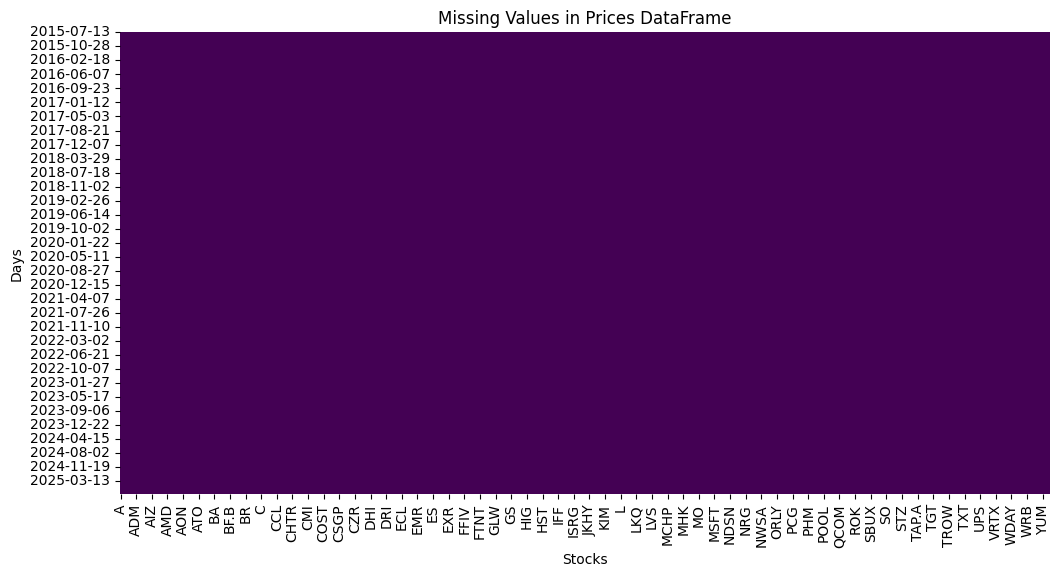

Stocks with missing values: []
Number of missing stocks: 0


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x600 with 0 Axes>

In [38]:
# let's plot the nans for the prices. in the x axis, only write the name of the stocks that have missing values

print("Heatmap of all pricesdf including those with missing values")
plt.figure(figsize=(12, 6))
sns.heatmap(pricesdf.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Prices DataFrame')
plt.xlabel('Stocks')
plt.ylabel('Days')
plt.show()

missing_stocks = pricesdf.columns[pricesdf.isnull().any()].tolist()
print("Stocks with missing values:", missing_stocks)
print("Number of missing stocks:", len(missing_stocks))
plt.figure(figsize=(12, 6))
sns.heatmap(pricesdf[missing_stocks].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Stocks')
plt.xlabel('Stocks')
plt.ylabel('Days')
plt.xticks(rotation=45)
plt.show()

In [39]:
# list all stocks that have missing values 
missing_stocks = pricesdf.columns[pricesdf.isnull().any()].tolist()
print("Stocks with missing values:", missing_stocks)
print("Number of missing stocks:", len(missing_stocks))

Stocks with missing values: []
Number of missing stocks: 0


In [40]:
# all stocks list 
all_stocks = pricesdf.columns.tolist()
print("All stocks:", all_stocks)

# save all stock names one by line in a text file
with open('all_stocks.txt', 'w') as f:
    for stock in all_stocks:
        f.write(stock + '\n')
        

All stocks: ['A', 'AAPL', 'ABBV', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APO', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBY', 'BDX', 'BEN', 'BF.A', 'BF.B', 'BG', 'BIIB', 'BK', 'BKNG', 'BLDR', 'BLK', 'BMY', 'BR', 'BRK.A', 'BRK.B', 'BRO', 'BSX', 'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTRA', 'CTSH', 'CUK', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DECK', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DLTR', 'DOC', 'DOV', 'DPZ', 'DRI', 'DT

In [105]:
# Function to find stocks that didn't exist up to a certain date
def find_stocks_with_initial_nans(df, min_consecutive_days=30):
    """
    Find stocks that have NaN values from the beginning up to a certain date,
    then no NaN values afterwards (indicating they started trading later)
    
    Parameters:
    df: DataFrame with stock prices
    min_consecutive_days: Minimum number of consecutive NaN days from start
    
    Returns:
    Dictionary with stock names and their first trading date
    """
    stocks_with_initial_nans = {}
    
    for stock in df.columns:
        stock_data = df[stock]
        
        # Find first non-NaN value
        first_valid_idx = stock_data.first_valid_index()
        
        if first_valid_idx is not None:
            # Check if there are NaN values from start to first valid index
            start_nans = stock_data.loc[:first_valid_idx].isna().sum() - 1  # -1 because first_valid_idx is not NaN
            
            # Check if there are any NaN values after first valid index
            after_first_valid = stock_data.loc[first_valid_idx:]
            nans_after = after_first_valid.isna().sum()
            
            # If stock has enough initial NaNs and no/few NaNs after first valid date
            if start_nans >= min_consecutive_days and nans_after <= 5:  # Allow up to 5 scattered NaNs
                stocks_with_initial_nans[stock] = {
                    'first_trading_date_index': first_valid_idx,
                    'initial_nan_days': start_nans,
                    'nans_after_start': nans_after
                }
    
    return stocks_with_initial_nans

# Find stocks that didn't exist initially
initial_nan_stocks = find_stocks_with_initial_nans(pricesdf, min_consecutive_days=30)

print(f"Found {len(initial_nan_stocks)} stocks that didn't exist initially:")
print("=" * 60)

for stock, info in initial_nan_stocks.items():
    print(f"{stock}:")
    print(f"  - First trading at index: {info['first_trading_date_index']}")
    print(f"  - Initial NaN days: {info['initial_nan_days']}")
    print(f"  - NaNs after start: {info['nans_after_start']}")
    print()

Found 30 stocks that didn't exist initially:
ABNB:
  - First trading at index: 2020-12-10
  - Initial NaN days: 1364
  - NaNs after start: 0

AMCR:
  - First trading at index: 2019-06-11
  - Initial NaN days: 984
  - NaNs after start: 0

BKR:
  - First trading at index: 2017-07-05
  - Initial NaN days: 498
  - NaNs after start: 0

CARR:
  - First trading at index: 2020-04-03
  - Initial NaN days: 1190
  - NaNs after start: 0

CEG:
  - First trading at index: 2022-02-02
  - Initial NaN days: 1652
  - NaNs after start: 0

CRWD:
  - First trading at index: 2019-06-12
  - Initial NaN days: 985
  - NaNs after start: 0

CTVA:
  - First trading at index: 2019-06-03
  - Initial NaN days: 978
  - NaNs after start: 0

DELL:
  - First trading at index: 2018-12-28
  - Initial NaN days: 872
  - NaNs after start: 0

DOW:
  - First trading at index: 2019-04-02
  - Initial NaN days: 936
  - NaNs after start: 0

FOX:
  - First trading at index: 2019-03-19
  - Initial NaN days: 926
  - NaNs after start:

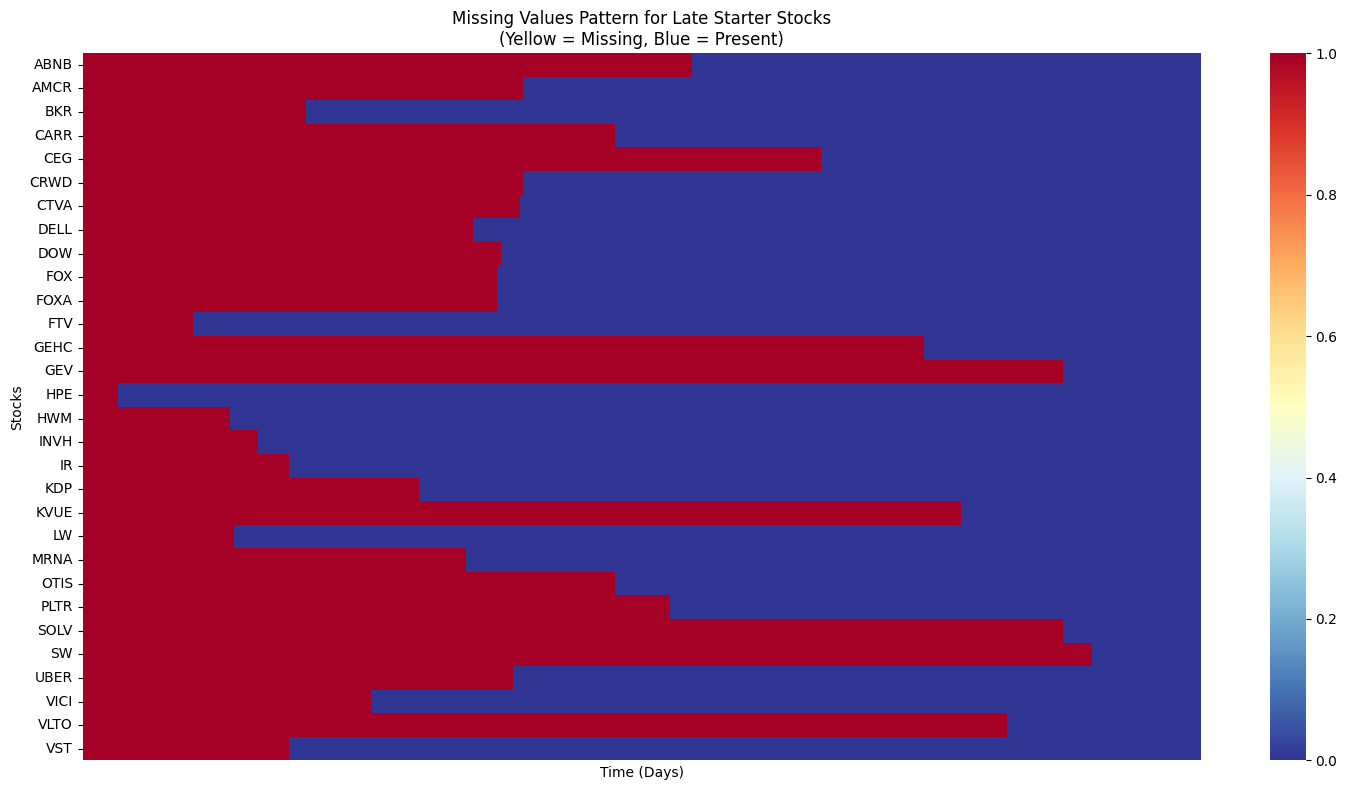


Summary of Late Starter Stocks:
Total stocks that started trading later: 30
Earliest start index: 2015-11-02
Latest start index: 2024-07-08

Breakdown by start period:
Early period starters (first 1/3): 10 stocks
Mid period starters (middle 1/3): 14 stocks
Late period starters (last 1/3): 6 stocks


In [110]:
# Visualize the pattern of stocks that started trading later
if initial_nan_stocks:
    # Create a DataFrame for visualization
    late_starters = list(initial_nan_stocks.keys())
    
    # Plot the missing values pattern for these specific stocks
    plt.figure(figsize=(15, 8))
    
    # Create a heatmap for late starter stocks
    late_starter_data = pricesdf[late_starters]
    sns.heatmap(late_starter_data.isnull().T, 
                cbar=True, 
                cmap='RdYlBu_r',
                xticklabels=False,  # Don't show all date labels
                yticklabels=True)
    
    plt.title('Missing Values Pattern for Late Starter Stocks\n(Yellow = Missing, Blue = Present)')
    plt.xlabel('Time (Days)')
    plt.ylabel('Stocks')
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nSummary of Late Starter Stocks:")
    print(f"Total stocks that started trading later: {len(late_starters)}")
    
    # Find the earliest and latest start dates
    start_indices = [info['first_trading_date_index'] for info in initial_nan_stocks.values()]
    print(f"Earliest start index: {min(start_indices)}")
    print(f"Latest start index: {max(start_indices)}")
    
    # Group by start date ranges using index position
    def get_index_position(date_str):
        try:
            return pricesdf.index.get_loc(date_str)
        except KeyError:
            return None

    early_starters = []
    mid_starters = []
    late_late_starters = []
    total_len = len(pricesdf)
    for stock, info in initial_nan_stocks.items():
        idx_pos = get_index_position(info['first_trading_date_index'])
        if idx_pos is not None:
            if idx_pos < total_len // 3:
                early_starters.append(stock)
            elif total_len // 3 <= idx_pos < 2 * total_len // 3:
                mid_starters.append(stock)
            else:
                late_late_starters.append(stock)

    print(f"\nBreakdown by start period:")
    print(f"Early period starters (first 1/3): {len(early_starters)} stocks")
    print(f"Mid period starters (middle 1/3): {len(mid_starters)} stocks") 
    print(f"Late period starters (last 1/3): {len(late_late_starters)} stocks")
else:
    print("No stocks found that match the late starter pattern")

In [111]:
# Enhanced function for strictly zero NaN values after start date
def find_stocks_with_strict_pattern(df, min_consecutive_days=30, max_nans_after=0):
    """
    Find stocks that have NaN values from the beginning up to a certain date,
    then EXACTLY zero NaN values afterwards (strict pattern)
    
    Parameters:
    df: DataFrame with stock prices
    min_consecutive_days: Minimum number of consecutive NaN days from start
    max_nans_after: Maximum allowed NaN values after first trading date (default 0 for strict)
    
    Returns:
    Dictionary with stock names and their trading information
    """
    strict_pattern_stocks = {}
    
    for stock in df.columns:
        stock_data = df[stock]
        
        # Find first non-NaN value
        first_valid_idx = stock_data.first_valid_index()
        
        if first_valid_idx is not None:
            # Check if there are NaN values from start to first valid index
            start_nans = stock_data.loc[:first_valid_idx].isna().sum() - 1
            
            # Check NaN values after first valid index (strict check)
            after_first_valid = stock_data.loc[first_valid_idx:]
            nans_after = after_first_valid.isna().sum()
            
            # Strict pattern: enough initial NaNs and exactly 0 (or very few) NaNs after
            if start_nans >= min_consecutive_days and nans_after <= max_nans_after:
                strict_pattern_stocks[stock] = {
                    'first_trading_date_index': first_valid_idx,
                    'initial_nan_days': start_nans,
                    'nans_after_start': nans_after,
                    'total_trading_days': len(after_first_valid),
                    'completeness_ratio': (len(after_first_valid) - nans_after) / len(after_first_valid)
                }
    
    return strict_pattern_stocks

# Find stocks with strict pattern (exactly 0 NaN values after start)
strict_stocks = find_stocks_with_strict_pattern(pricesdf, min_consecutive_days=30, max_nans_after=0)

print(f"Found {len(strict_stocks)} stocks with STRICT pattern (0 NaN after start):")
print("=" * 70)

for stock, info in strict_stocks.items():
    print(f"{stock}:")
    print(f"  - First trading at index: {info['first_trading_date_index']}")
    print(f"  - Initial NaN days: {info['initial_nan_days']}")
    print(f"  - NaNs after start: {info['nans_after_start']}")
    print(f"  - Total trading days: {info['total_trading_days']}")
    print(f"  - Data completeness: {info['completeness_ratio']:.1%}")
    print()

# Compare with allowing up to 5 NaN values after start
lenient_stocks = find_stocks_with_strict_pattern(pricesdf, min_consecutive_days=30, max_nans_after=5)

print(f"\nComparison:")
print(f"Stocks with 0 NaN after start: {len(strict_stocks)}")
print(f"Stocks with ≤5 NaN after start: {len(lenient_stocks)}")
print(f"Difference: {len(lenient_stocks) - len(strict_stocks)} stocks have some missing data after start")

Found 30 stocks with STRICT pattern (0 NaN after start):
ABNB:
  - First trading at index: 2020-12-10
  - Initial NaN days: 1364
  - NaNs after start: 0
  - Total trading days: 1138
  - Data completeness: 100.0%

AMCR:
  - First trading at index: 2019-06-11
  - Initial NaN days: 984
  - NaNs after start: 0
  - Total trading days: 1518
  - Data completeness: 100.0%

BKR:
  - First trading at index: 2017-07-05
  - Initial NaN days: 498
  - NaNs after start: 0
  - Total trading days: 2004
  - Data completeness: 100.0%

CARR:
  - First trading at index: 2020-04-03
  - Initial NaN days: 1190
  - NaNs after start: 0
  - Total trading days: 1312
  - Data completeness: 100.0%

CEG:
  - First trading at index: 2022-02-02
  - Initial NaN days: 1652
  - NaNs after start: 0
  - Total trading days: 850
  - Data completeness: 100.0%

CRWD:
  - First trading at index: 2019-06-12
  - Initial NaN days: 985
  - NaNs after start: 0
  - Total trading days: 1517
  - Data completeness: 100.0%

CTVA:
  - Fir

In [112]:
# Extract stock lists for further use
print("Stock Lists for Further Analysis:")
print("=" * 50)

# List of stocks with strict pattern (0 NaN after start)
strict_stocks_list = list(strict_stocks.keys())
print(f"Strict pattern stocks (0 NaN after start): {len(strict_stocks_list)}")
print(f"Stock tickers: {strict_stocks_list}")
print()

# List of stocks with lenient pattern (≤5 NaN after start)
lenient_stocks_list = list(lenient_stocks.keys())
print(f"Lenient pattern stocks (≤5 NaN after start): {len(lenient_stocks_list)}")
print(f"Stock tickers: {lenient_stocks_list}")
print()

# List of stocks that have some missing data after start (difference between lenient and strict)
problematic_stocks = [stock for stock in lenient_stocks_list if stock not in strict_stocks_list]
print(f"Stocks with some missing data after start: {len(problematic_stocks)}")
print(f"Stock tickers: {problematic_stocks}")
print()

# Create a clean dataset with only stocks that have complete data after start
clean_stocks_data = pricesdf[strict_stocks_list]
print(f"Shape of clean dataset (strict stocks only): {clean_stocks_data.shape}")

# Save the clean dataset if needed
# clean_stocks_data.to_csv('clean_prices_strict_pattern.csv', index=False)
# print("Clean dataset saved to 'clean_prices_strict_pattern.csv'")

# Example: Show first and last few rows of a strict pattern stock
if strict_stocks_list:
    example_stock = strict_stocks_list[0]
    print(f"\nExample stock ({example_stock}) data pattern:")
    print("First 10 values:")
    print(pricesdf[example_stock].head(10))
    print("\nLast 10 values:")
    print(pricesdf[example_stock].tail(10))

Stock Lists for Further Analysis:
Strict pattern stocks (0 NaN after start): 30
Stock tickers: ['ABNB', 'AMCR', 'BKR', 'CARR', 'CEG', 'CRWD', 'CTVA', 'DELL', 'DOW', 'FOX', 'FOXA', 'FTV', 'GEHC', 'GEV', 'HPE', 'HWM', 'INVH', 'IR', 'KDP', 'KVUE', 'LW', 'MRNA', 'OTIS', 'PLTR', 'SOLV', 'SW', 'UBER', 'VICI', 'VLTO', 'VST']

Lenient pattern stocks (≤5 NaN after start): 30
Stock tickers: ['ABNB', 'AMCR', 'BKR', 'CARR', 'CEG', 'CRWD', 'CTVA', 'DELL', 'DOW', 'FOX', 'FOXA', 'FTV', 'GEHC', 'GEV', 'HPE', 'HWM', 'INVH', 'IR', 'KDP', 'KVUE', 'LW', 'MRNA', 'OTIS', 'PLTR', 'SOLV', 'SW', 'UBER', 'VICI', 'VLTO', 'VST']

Stocks with some missing data after start: 0
Stock tickers: []

Shape of clean dataset (strict stocks only): (2503, 30)

Example stock (ABNB) data pattern:
First 10 values:
date
2015-07-13   NaN
2015-07-14   NaN
2015-07-15   NaN
2015-07-16   NaN
2015-07-17   NaN
2015-07-20   NaN
2015-07-21   NaN
2015-07-22   NaN
2015-07-23   NaN
2015-07-24   NaN
Name: ABNB, dtype: float64

Last 10 values

Found 6 stocks that exited the market:
CMCSK: last trading at index 2015-12-11, 2394 NaN days at end
DISCB: last trading at index 2022-04-08, 802 NaN days at end
DISCK: last trading at index 2022-04-08, 802 NaN days at end
GMCR: last trading at index 2016-03-02, 2340 NaN days at end
HUB.A: last trading at index 2015-12-23, 2386 NaN days at end
STZ.B: last trading at index 2022-11-10, 653 NaN days at end


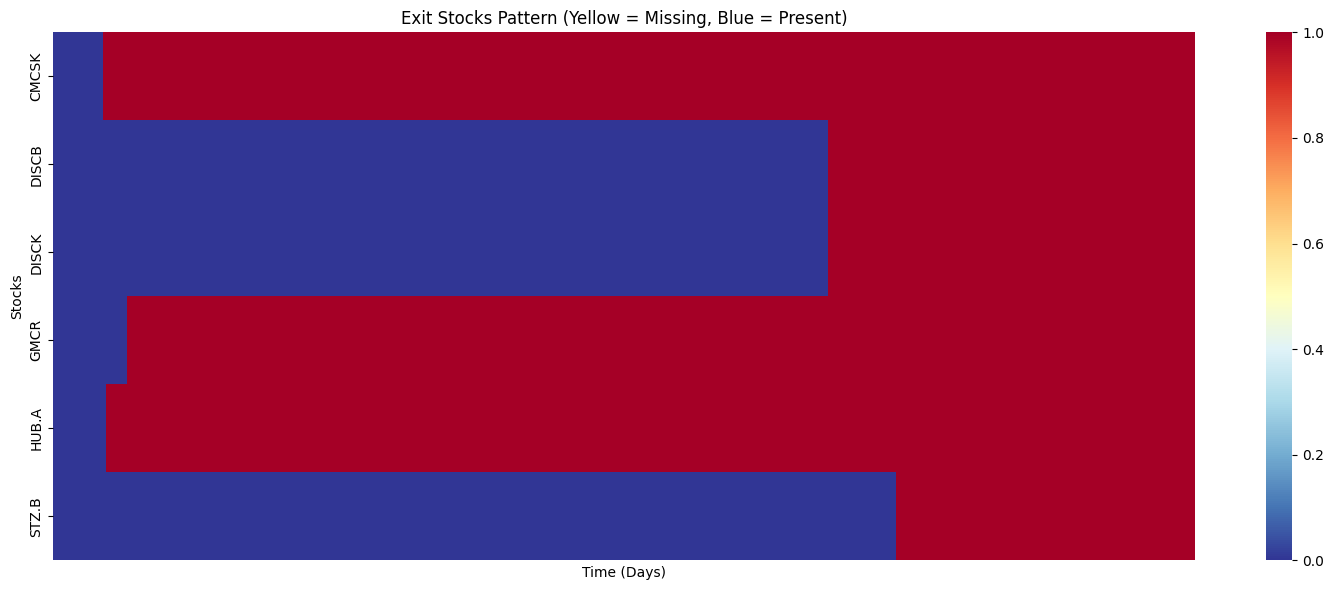

In [113]:
# Find stocks that exited the market (0 NaN initially, then all NaN at the end)
def find_exit_stocks(df, min_consecutive_end_nans=30):
    exit_stocks = {}
    
    for stock in df.columns:
        stock_data = df[stock]
        last_valid_idx = stock_data.last_valid_index()
        
        if last_valid_idx is not None:
            # Check NaN values from last valid index to end
            end_nans = stock_data.loc[last_valid_idx:].isna().sum() - 1
            
            # Check if stock has complete data initially (first valid is at/near start)
            first_valid_idx = stock_data.first_valid_index()
            initial_nans = stock_data.loc[:first_valid_idx].isna().sum() - 1 if first_valid_idx else 0
            
            if end_nans >= min_consecutive_end_nans and initial_nans <= 10:
                exit_stocks[stock] = {
                    'last_trading_date_index': last_valid_idx,
                    'final_nan_days': end_nans
                }
    
    return exit_stocks

exit_stocks = find_exit_stocks(pricesdf, min_consecutive_end_nans=30)
print(f"Found {len(exit_stocks)} stocks that exited the market:")
for stock, info in exit_stocks.items():
    print(f"{stock}: last trading at index {info['last_trading_date_index']}, {info['final_nan_days']} NaN days at end")

# Visualize exit pattern
if exit_stocks:
    exit_stock_list = list(exit_stocks.keys())
    plt.figure(figsize=(15, 6))
    sns.heatmap(pricesdf[exit_stock_list].isnull().T, cbar=True, cmap='RdYlBu_r', 
                xticklabels=False, yticklabels=True)
    plt.title('Exit Stocks Pattern (Yellow = Missing, Blue = Present)')
    plt.xlabel('Time (Days)')
    plt.ylabel('Stocks')
    plt.tight_layout()
    plt.show()

### Report for prices before cleaning

The data is taken from the CRSP database, for the S&P500 stocks shown above. 

As we can see, we have 39 stocks that have missing values. This number is rather small when compared to the universe we have access to. 

Some stocks ve

## Data Cleaning for prices.csv

In [118]:
# for now, we remove stocks (columns) that have missing values

full_prices = pricesdf.dropna(axis=1, how='any')
full_prices.to_csv('prices.csv', index=True)
full_prices

,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2015-07-13,39.96,502.64,69.57,49.72,206.76,100.55,81.44,61.87,47.50,81.73,...,17.765150,31.65,107.89,33.54,82.42,36.06,91.11,107.63,110.51,47.04
2015-07-14,40.49,502.44,69.80,50.20,207.15,100.74,81.89,62.62,47.79,81.89,...,17.742500,31.26,107.26,33.54,83.11,36.49,91.99,107.40,114.06,47.46
2015-07-15,40.13,507.28,69.75,49.31,207.03,99.95,82.12,62.92,47.46,82.50,...,17.723625,31.21,103.42,33.62,82.76,35.95,88.88,107.13,111.99,47.11
2015-07-16,40.34,514.04,69.99,49.77,208.17,101.45,82.52,62.83,47.85,82.90,...,17.738725,30.96,103.80,34.12,82.91,36.02,88.25,107.77,114.10,48.00
2015-07-17,39.95,518.48,69.99,49.90,207.90,100.48,82.10,62.46,48.02,82.39,...,17.742500,30.48,101.71,33.70,82.61,35.81,87.88,107.50,114.18,47.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,116.09,195.64,185.48,132.28,90.15,312.03,382.68,227.44,54.10,307.62,...,297.790000,25.87,87.28,65.65,114.00,125.37,139.99,90.21,289.36,161.67
2025-06-18,115.52,196.58,185.49,132.41,90.30,306.38,378.04,229.65,53.99,306.77,...,297.500000,25.97,86.91,66.28,113.19,125.13,138.36,90.55,291.73,155.06
2025-06-20,115.56,201.00,185.30,132.99,90.17,285.37,376.92,228.35,53.61,306.26,...,299.000000,26.18,88.49,66.64,114.70,124.46,139.06,91.22,294.04,157.17


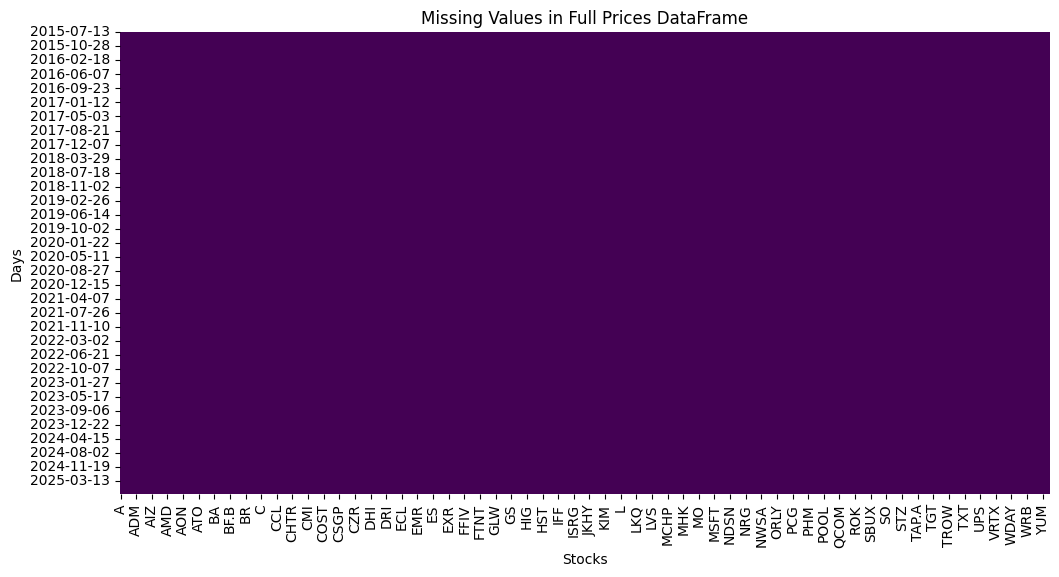

In [119]:
plt.figure(figsize=(12, 6))
sns.heatmap(full_prices.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Full Prices DataFrame')
plt.xlabel('Stocks')
plt.ylabel('Days')
plt.show()

# bid_ask_spreads.csv

In [63]:
bas = pd.read_csv('bid_ask_spreads.csv', parse_dates=['Date'], index_col='Date')

bas

,BID_A,ASK_A,BID_AAPL,ASK_AAPL,BID_ABBV,ASK_ABBV,BID_ABNB,ASK_ABNB,BID_ABT,ASK_ABT,...,BID_XYL,ASK_XYL,BID_YUM,ASK_YUM,BID_ZBH,ASK_ZBH,BID_ZBRA,ASK_ZBRA,BID_ZTS,ASK_ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-13,39.95,39.96,NaN,NaN,69.57,69.58,NaN,NaN,NaN,NaN,...,36.04,36.06,65.513010,65.520200,104.356131,104.365832,110.46,110.51,47.03,47.04
2015-07-14,40.49,40.50,31.4000,31.4025,69.80,69.81,NaN,NaN,50.20,50.21,...,36.48,36.49,66.145777,66.167349,104.142704,104.162107,114.05,114.06,47.45,47.46
2015-07-15,40.12,40.13,31.7050,31.7100,69.76,69.77,NaN,NaN,49.32,49.33,...,35.95,35.96,63.916710,63.931091,103.938978,103.968082,111.99,112.02,47.12,47.14
2015-07-16,40.34,40.35,32.1250,32.1275,69.98,69.99,NaN,NaN,49.77,49.78,...,36.02,36.03,63.434944,63.449325,104.511351,104.540454,114.04,114.10,48.01,48.03
2015-07-17,39.94,39.95,32.4025,32.4050,69.98,69.99,NaN,NaN,49.89,49.90,...,35.81,35.83,63.190466,63.197656,104.288223,104.297924,114.17,114.19,47.80,47.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18,115.54,115.55,196.2300,196.2500,185.46,185.47,132.13,132.19,132.44,132.45,...,125.09,125.13,138.390000,138.400000,90.550000,90.560000,291.72,292.01,155.13,155.20
2025-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-20,115.57,115.60,200.9200,200.9300,185.18,185.20,131.68,131.71,133.05,133.06,...,124.47,124.48,139.050000,139.060000,91.200000,91.210000,293.90,294.22,157.17,157.28


### THIS IS KASPER's DATA

In [12]:
ogbas = pd.read_csv('../../data-markowitz/spreads.csv')

# name first column to Date
ogbas.rename(columns={ogbas.columns[0]: 'Date'}, inplace=True)
ogbas

,Date,T0,T1,T3,T4,T5,T6,T7,T8,T9,...,T89,T90,T92,T93,T94,T95,T96,T98,T99,T100
0,2000-01-04,0.000412,0.002182,0.003110,0.001303,0.000884,0.000751,0.001120,0.003959,0.002810,...,0.000992,0.002368,0.002791,0.000954,0.005440,0.001668,0.005970,0.001444,0.001372,0.001696
1,2000-01-05,0.000847,0.001042,0.001456,0.001261,0.001775,0.000734,0.001095,0.001900,0.001430,...,0.001944,0.002369,0.005529,0.000950,0.001708,0.003160,0.005952,0.002954,0.001296,0.001694
2,2000-01-06,0.001664,0.002120,0.001439,0.001212,0.000875,0.001408,0.003293,0.005876,0.002741,...,0.001889,0.002377,0.002701,0.000912,0.001646,0.005092,0.005848,0.001413,0.003935,0.001630
3,2000-01-07,0.000821,0.002125,0.002821,0.001170,0.000860,0.000693,0.001030,0.004007,0.002773,...,0.001759,0.002322,0.002582,0.000935,0.002959,0.003322,0.002943,0.004112,0.003903,0.001596
4,2000-01-10,0.000809,0.002136,0.001418,0.002421,0.001748,0.001422,0.001065,0.003480,0.004177,...,0.002749,0.002263,0.002601,0.000940,0.002972,0.001665,0.006079,0.001392,0.002567,0.001646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6186,2023-09-20,0.000064,0.000298,0.000247,0.000108,0.000067,0.000120,0.000171,0.000121,0.000248,...,0.000105,0.000140,0.000088,0.000063,0.000123,0.000280,0.000281,0.000099,0.000106,0.000466
6187,2023-09-21,0.000129,0.000300,0.000400,0.000294,0.000068,0.000061,0.000174,0.000121,0.000084,...,0.000309,0.000047,0.000090,0.000257,0.000124,0.000139,0.000024,0.000303,0.000218,0.000236
6188,2023-09-22,0.000065,0.000301,0.000051,0.000146,0.000069,0.000241,0.000347,0.000123,0.000252,...,0.000018,0.000048,0.000269,0.000260,0.000125,0.000141,0.000024,0.000102,0.000220,0.000243
6189,2023-09-25,0.000065,0.000302,0.000050,0.000182,0.000137,0.000059,0.000175,0.000123,0.000083,...,0.000380,0.000141,0.000357,0.000065,0.000125,0.000276,0.000412,0.000409,0.000110,0.000241


OGBAS BID-ASK SPREADS
Shape: (6191, 75)
Columns: ['Date', 'T0', 'T1', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T23', 'T25', 'T26', 'T28', 'T29', 'T30', 'T31', 'T33', 'T34', 'T35', 'T36', 'T37', 'T38', 'T39', 'T40', 'T43', 'T46', 'T47', 'T48', 'T50', 'T53', 'T55', 'T56', 'T57', 'T58', 'T59', 'T61', 'T64', 'T66', 'T67', 'T68', 'T69', 'T71', 'T73', 'T76', 'T77', 'T79', 'T80', 'T81', 'T83', 'T84', 'T85', 'T87', 'T89', 'T90', 'T92', 'T93', 'T94', 'T95', 'T96', 'T98', 'T99', 'T100']
Data types:
float64           74
datetime64[ns]     1
Name: count, dtype: int64
Date range: 2000-01-04 00:00:00 to 2023-09-26 00:00:00
Missing values: 0 (0.0%)

Key Statistics:
Overall mean: 0.000673
Overall min: 0.000000
Overall max: 0.160008
Overall std: 0.001444
Positive values: 99.4%
Negative values: 0.0%
Zero values: 0.6%


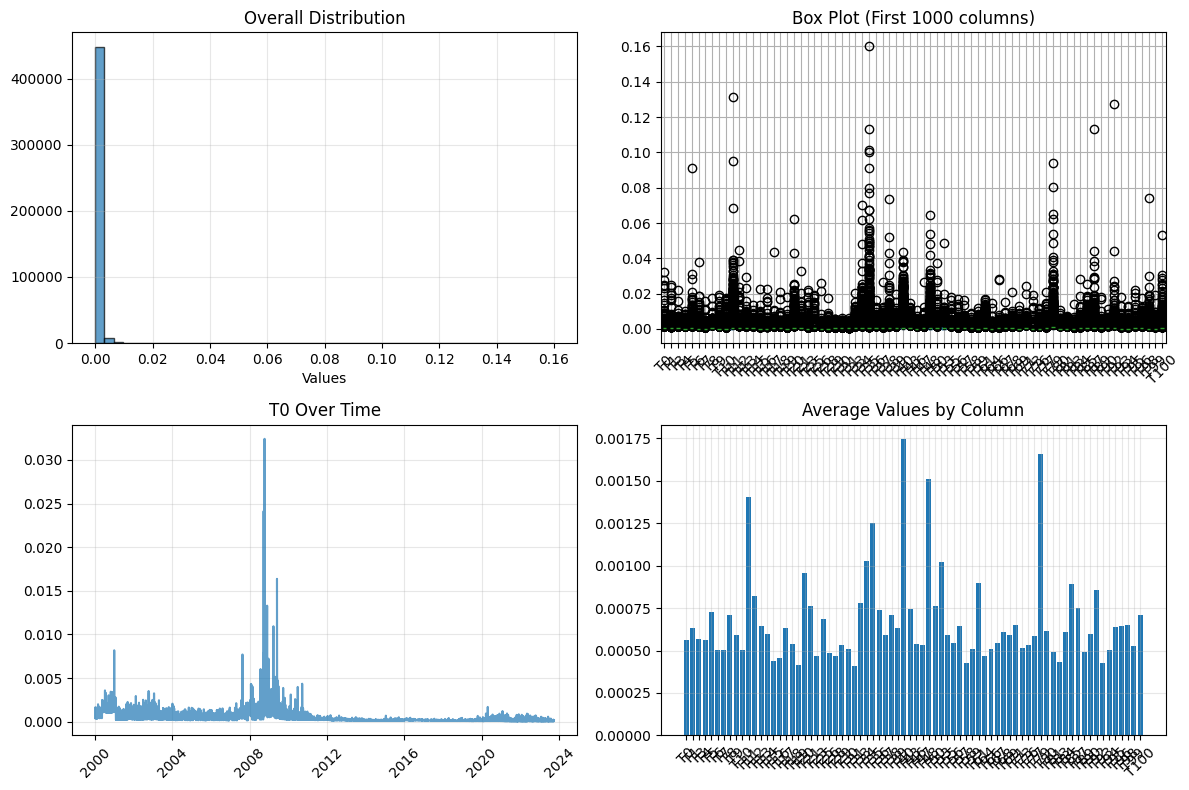


✓ All values non-negative: Yes
✓ Total numeric columns: 74
✓ Data completeness: 100.0%

Function returned summary: {'shape': (6191, 75), 'numeric_columns': 74, 'missing_percentage': np.float64(0.0), 'all_non_negative': np.True_, 'mean': np.float64(0.0006728105352159583), 'std': np.float64(0.001444119301899023)}


In [25]:
summary = explore_dataframe(ogbas, title="OGBAS Bid-Ask Spreads", date_col="Date")
print(f"\nFunction returned summary: {summary}")

# END OF KASPER DATA

In [64]:
bas

,BID_A,ASK_A,BID_AAPL,ASK_AAPL,BID_ABBV,ASK_ABBV,BID_ABNB,ASK_ABNB,BID_ABT,ASK_ABT,...,BID_XYL,ASK_XYL,BID_YUM,ASK_YUM,BID_ZBH,ASK_ZBH,BID_ZBRA,ASK_ZBRA,BID_ZTS,ASK_ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-13,39.95,39.96,NaN,NaN,69.57,69.58,NaN,NaN,NaN,NaN,...,36.04,36.06,65.513010,65.520200,104.356131,104.365832,110.46,110.51,47.03,47.04
2015-07-14,40.49,40.50,31.4000,31.4025,69.80,69.81,NaN,NaN,50.20,50.21,...,36.48,36.49,66.145777,66.167349,104.142704,104.162107,114.05,114.06,47.45,47.46
2015-07-15,40.12,40.13,31.7050,31.7100,69.76,69.77,NaN,NaN,49.32,49.33,...,35.95,35.96,63.916710,63.931091,103.938978,103.968082,111.99,112.02,47.12,47.14
2015-07-16,40.34,40.35,32.1250,32.1275,69.98,69.99,NaN,NaN,49.77,49.78,...,36.02,36.03,63.434944,63.449325,104.511351,104.540454,114.04,114.10,48.01,48.03
2015-07-17,39.94,39.95,32.4025,32.4050,69.98,69.99,NaN,NaN,49.89,49.90,...,35.81,35.83,63.190466,63.197656,104.288223,104.297924,114.17,114.19,47.80,47.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18,115.54,115.55,196.2300,196.2500,185.46,185.47,132.13,132.19,132.44,132.45,...,125.09,125.13,138.390000,138.400000,90.550000,90.560000,291.72,292.01,155.13,155.20
2025-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-20,115.57,115.60,200.9200,200.9300,185.18,185.20,131.68,131.71,133.05,133.06,...,124.47,124.48,139.050000,139.060000,91.200000,91.210000,293.90,294.22,157.17,157.28


In [67]:
# let's check for the length of the instersection for the dates between bas and pricesdf. let's set both indices to datetime format
bas.index = pd.to_datetime(bas.index)
pricesdf.index = pd.to_datetime(pricesdf.index)
intersection_dates = bas.index.intersection(pricesdf.index)

# dates that are in bas but not in pricesdf
bas_only_dates = bas.index.difference(pricesdf.index)
print(f"Number of dates in bas but not in pricesdf: {len(bas_only_dates)}")
print("First few dates in bas but not in pricesdf:")
print(bas_only_dates[:5])
# dates that are in pricesdf but not in bas
pricesdf_only_dates = pricesdf.index.difference(bas.index)
print(f"Number of dates in pricesdf but not in bas: {len(pricesdf_only_dates)}")
print("First few dates in pricesdf but not in bas:")
print(pricesdf_only_dates[:5])

#total number of dates in bas and pricesdf
print(f"Total number of dates in bas: {len(bas.index)}")
print(f"Total number of dates in pricesdf: {len(pricesdf.index)}")
# let's see some statistics about the intersection
print(f"Number of intersection dates: {len(intersection_dates)}")

Number of dates in bas but not in pricesdf: 57
First few dates in bas but not in pricesdf:
DatetimeIndex(['2015-09-07', '2015-11-26', '2016-01-18', '2016-02-15',
               '2016-07-04'],
              dtype='datetime64[ns]', name='Date', freq=None)
Number of dates in pricesdf but not in bas: 0
First few dates in pricesdf but not in bas:
DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)
Total number of dates in bas: 2560
Total number of dates in pricesdf: 2503
Number of intersection dates: 2503


In [68]:
# for bas, keep only the intersection dates
bas = bas.loc[intersection_dates]

bas

,BID_A,ASK_A,BID_AAPL,ASK_AAPL,BID_ABBV,ASK_ABBV,BID_ABNB,ASK_ABNB,BID_ABT,ASK_ABT,...,BID_XYL,ASK_XYL,BID_YUM,ASK_YUM,BID_ZBH,ASK_ZBH,BID_ZBRA,ASK_ZBRA,BID_ZTS,ASK_ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-13,39.95,39.96,NaN,NaN,69.57,69.58,NaN,NaN,NaN,NaN,...,36.04,36.06,65.513010,65.520200,104.356131,104.365832,110.46,110.51,47.03,47.04
2015-07-14,40.49,40.50,31.4000,31.4025,69.80,69.81,NaN,NaN,50.20,50.21,...,36.48,36.49,66.145777,66.167349,104.142704,104.162107,114.05,114.06,47.45,47.46
2015-07-15,40.12,40.13,31.7050,31.7100,69.76,69.77,NaN,NaN,49.32,49.33,...,35.95,35.96,63.916710,63.931091,103.938978,103.968082,111.99,112.02,47.12,47.14
2015-07-16,40.34,40.35,32.1250,32.1275,69.98,69.99,NaN,NaN,49.77,49.78,...,36.02,36.03,63.434944,63.449325,104.511351,104.540454,114.04,114.10,48.01,48.03
2015-07-17,39.94,39.95,32.4025,32.4050,69.98,69.99,NaN,NaN,49.89,49.90,...,35.81,35.83,63.190466,63.197656,104.288223,104.297924,114.17,114.19,47.80,47.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,116.03,116.04,195.5900,195.6500,185.42,185.46,133.37,133.38,132.23,132.25,...,125.39,125.40,139.980000,139.990000,90.190000,90.200000,289.30,289.43,161.57,161.58
2025-06-18,115.54,115.55,196.2300,196.2500,185.46,185.47,132.13,132.19,132.44,132.45,...,125.09,125.13,138.390000,138.400000,90.550000,90.560000,291.72,292.01,155.13,155.20
2025-06-20,115.57,115.60,200.9200,200.9300,185.18,185.20,131.68,131.71,133.05,133.06,...,124.47,124.48,139.050000,139.060000,91.200000,91.210000,293.90,294.22,157.17,157.28


BID-ASK SPREADS NAN PATTERN ANALYSIS
Overall NaN Statistics:
Total cells: 2,518,018
Total NaN values: 64,403
Overall NaN percentage: 2.56%

Column-wise NaN Analysis:
Columns with NaN values: 264 out of 1006
Worst 5 columns for NaN values:
  BID_SW: 2261 NaNs (90.3%)
  ASK_SW: 2261 NaNs (90.3%)
  ASK_GEV: 2192 NaNs (87.6%)
  BID_GEV: 2192 NaNs (87.6%)
  BID_SOLV: 2191 NaNs (87.5%)

Row-wise NaN Analysis:
Rows with NaN values: 2265 out of 2503
Average NaNs per affected row: 28.4
Max NaNs in a single row: 232

Pattern Analysis:
Complete columns (no NaNs): 742
All-NaN columns: 0
Initial NaN pattern columns: 232
Final NaN pattern columns: 0
Scattered NaN pattern columns: 32

Initial NaN Patterns (first 1+ rows are NaN):
  BID_AAPL: 1 initial NaNs, 100.0% complete
  ASK_AAPL: 1 initial NaNs, 100.0% complete
  BID_ABNB: 1365 initial NaNs, 45.5% complete

Scattered NaN Patterns:
  BID_ADI: 1 scattered NaNs, 100.0% complete
  ASK_ADI: 1 scattered NaNs, 100.0% complete
  BID_BIIB: 2 scattered Na

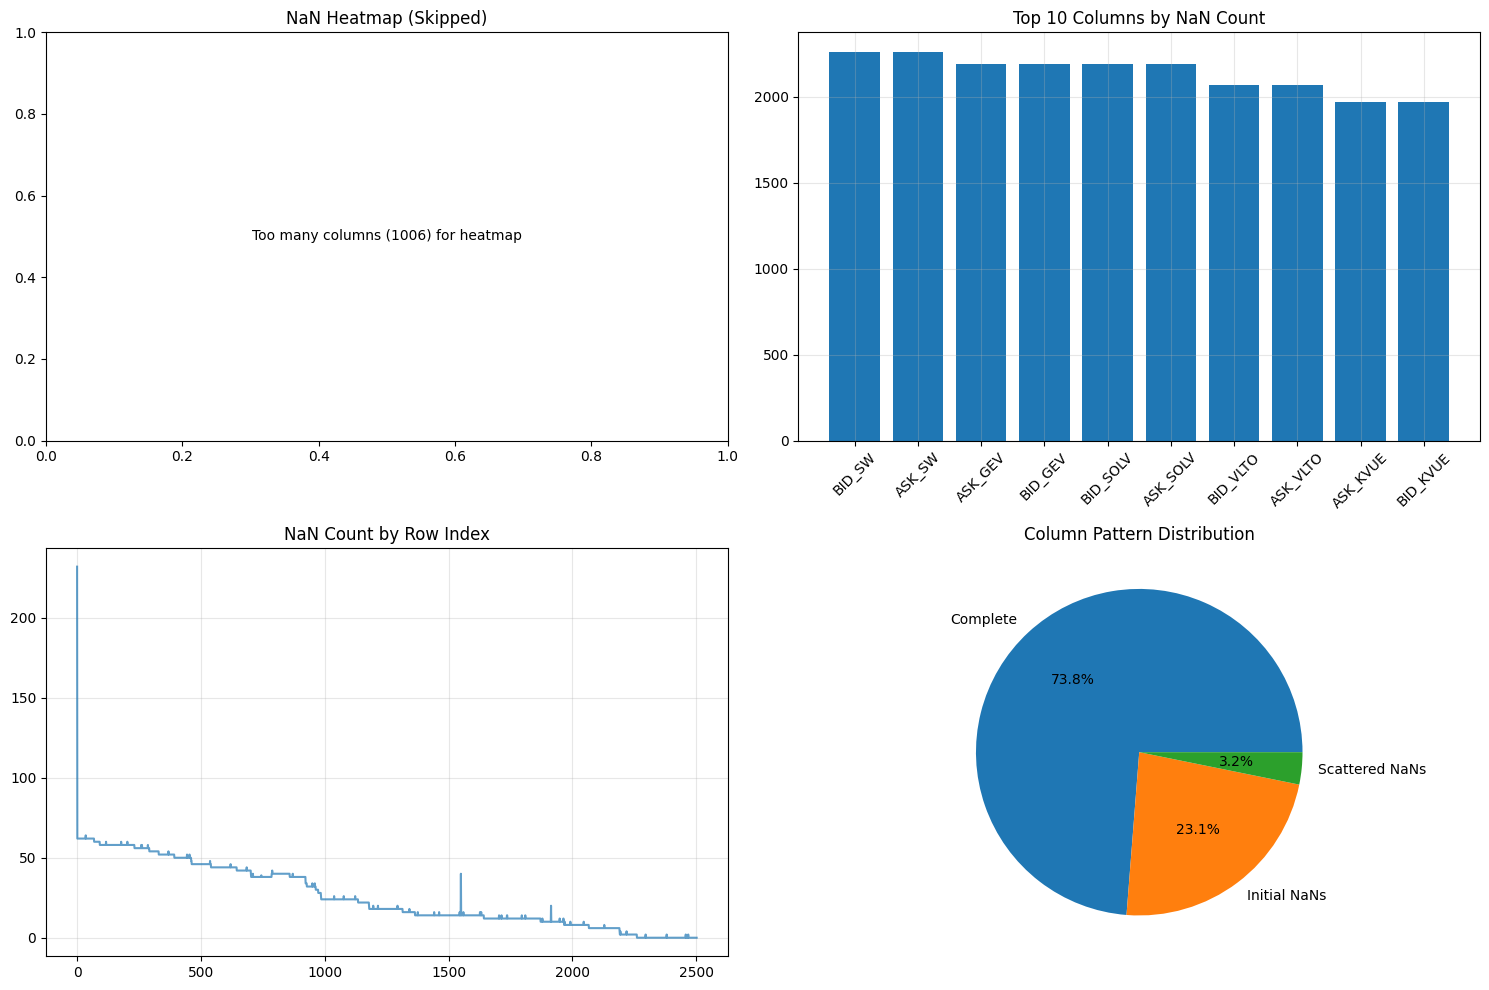

{'total_nans': np.int64(64403),
 'nan_percentage': np.float64(2.5576862437043735),
 'columns_with_nans': 264,
 'rows_with_nans': 2265,
 'patterns': {'initial_nans': {'BID_AAPL': {'first_valid_index': Timestamp('2015-07-14 00:00:00'),
    'initial_nan_count': 1,
    'data_completeness': np.float64(99.96004794246903)},
   'ASK_AAPL': {'first_valid_index': Timestamp('2015-07-14 00:00:00'),
    'initial_nan_count': 1,
    'data_completeness': np.float64(99.96004794246903)},
   'BID_ABNB': {'first_valid_index': Timestamp('2020-12-10 00:00:00'),
    'initial_nan_count': 1365,
    'data_completeness': np.float64(45.46544147023572)},
   'ASK_ABNB': {'first_valid_index': Timestamp('2020-12-10 00:00:00'),
    'initial_nan_count': 1365,
    'data_completeness': np.float64(45.46544147023572)},
   'BID_ABT': {'first_valid_index': Timestamp('2015-07-14 00:00:00'),
    'initial_nan_count': 1,
    'data_completeness': np.float64(99.96004794246903)},
   'ASK_ABT': {'first_valid_index': Timestamp('2015-

In [72]:
analyze_nan_patterns(bas, title="Bid-Ask Spreads NaN Pattern Analysis", date_col="Date", min_consecutive_days=1)

In [71]:
# intersect stock names (columns) with pricesdf and give some statistics before that 
common_stocks = set(bas.columns).intersection(set(pricesdf.columns))
print(f"Number of common stocks: {len(common_stocks)}")
print("Common stocks:", common_stocks)



Number of common stocks: 0
Common stocks: set()


In [69]:
# for each stock, we calculate the bid-ask spread as the difference between the ask and bid prices divided by the mid price and name the column as the stock ticker

for stock in all_stocks: 
    if stock in ogbas.columns:
        bas[stock] = (ogbas['ASK_' + stock] - ogbas['BID_' + stock]) / ((ogbas['ASK_' + stock] + ogbas['BID_' + stock]) / 2)

bas

,BID_A,ASK_A,BID_AAPL,ASK_AAPL,BID_ABBV,ASK_ABBV,BID_ABNB,ASK_ABNB,BID_ABT,ASK_ABT,...,BID_XYL,ASK_XYL,BID_YUM,ASK_YUM,BID_ZBH,ASK_ZBH,BID_ZBRA,ASK_ZBRA,BID_ZTS,ASK_ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-13,39.95,39.96,NaN,NaN,69.57,69.58,NaN,NaN,NaN,NaN,...,36.04,36.06,65.513010,65.520200,104.356131,104.365832,110.46,110.51,47.03,47.04
2015-07-14,40.49,40.50,31.4000,31.4025,69.80,69.81,NaN,NaN,50.20,50.21,...,36.48,36.49,66.145777,66.167349,104.142704,104.162107,114.05,114.06,47.45,47.46
2015-07-15,40.12,40.13,31.7050,31.7100,69.76,69.77,NaN,NaN,49.32,49.33,...,35.95,35.96,63.916710,63.931091,103.938978,103.968082,111.99,112.02,47.12,47.14
2015-07-16,40.34,40.35,32.1250,32.1275,69.98,69.99,NaN,NaN,49.77,49.78,...,36.02,36.03,63.434944,63.449325,104.511351,104.540454,114.04,114.10,48.01,48.03
2015-07-17,39.94,39.95,32.4025,32.4050,69.98,69.99,NaN,NaN,49.89,49.90,...,35.81,35.83,63.190466,63.197656,104.288223,104.297924,114.17,114.19,47.80,47.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,116.03,116.04,195.5900,195.6500,185.42,185.46,133.37,133.38,132.23,132.25,...,125.39,125.40,139.980000,139.990000,90.190000,90.200000,289.30,289.43,161.57,161.58
2025-06-18,115.54,115.55,196.2300,196.2500,185.46,185.47,132.13,132.19,132.44,132.45,...,125.09,125.13,138.390000,138.400000,90.550000,90.560000,291.72,292.01,155.13,155.20
2025-06-20,115.57,115.60,200.9200,200.9300,185.18,185.20,131.68,131.71,133.05,133.06,...,124.47,124.48,139.050000,139.060000,91.200000,91.210000,293.90,294.22,157.17,157.28


BAS DATAFRAME NAN ANALYSIS
Overall NaN Statistics:
Total cells: 2,518,018
Total NaN values: 64,403
Overall NaN percentage: 2.56%

Column-wise NaN Analysis:
Columns with NaN values: 264 out of 1006
Worst 5 columns for NaN values:
  BID_SW: 2261 NaNs (90.3%)
  ASK_SW: 2261 NaNs (90.3%)
  ASK_GEV: 2192 NaNs (87.6%)
  BID_GEV: 2192 NaNs (87.6%)
  BID_SOLV: 2191 NaNs (87.5%)

Row-wise NaN Analysis:
Rows with NaN values: 2265 out of 2503
Average NaNs per affected row: 28.4
Max NaNs in a single row: 232

Pattern Analysis:
Complete columns (no NaNs): 742
All-NaN columns: 0
Initial NaN pattern columns: 62
Final NaN pattern columns: 0
Scattered NaN pattern columns: 50

Initial NaN Patterns (first 30+ rows are NaN):
  BID_ABNB: 1365 initial NaNs, 45.5% complete
  ASK_ABNB: 1365 initial NaNs, 45.5% complete
  BID_AMCR: 985 initial NaNs, 60.6% complete

Scattered NaN Patterns:
  BID_ADI: 1 scattered NaNs, 100.0% complete
  ASK_ADI: 1 scattered NaNs, 100.0% complete
  BID_BIIB: 2 scattered NaNs, 99.

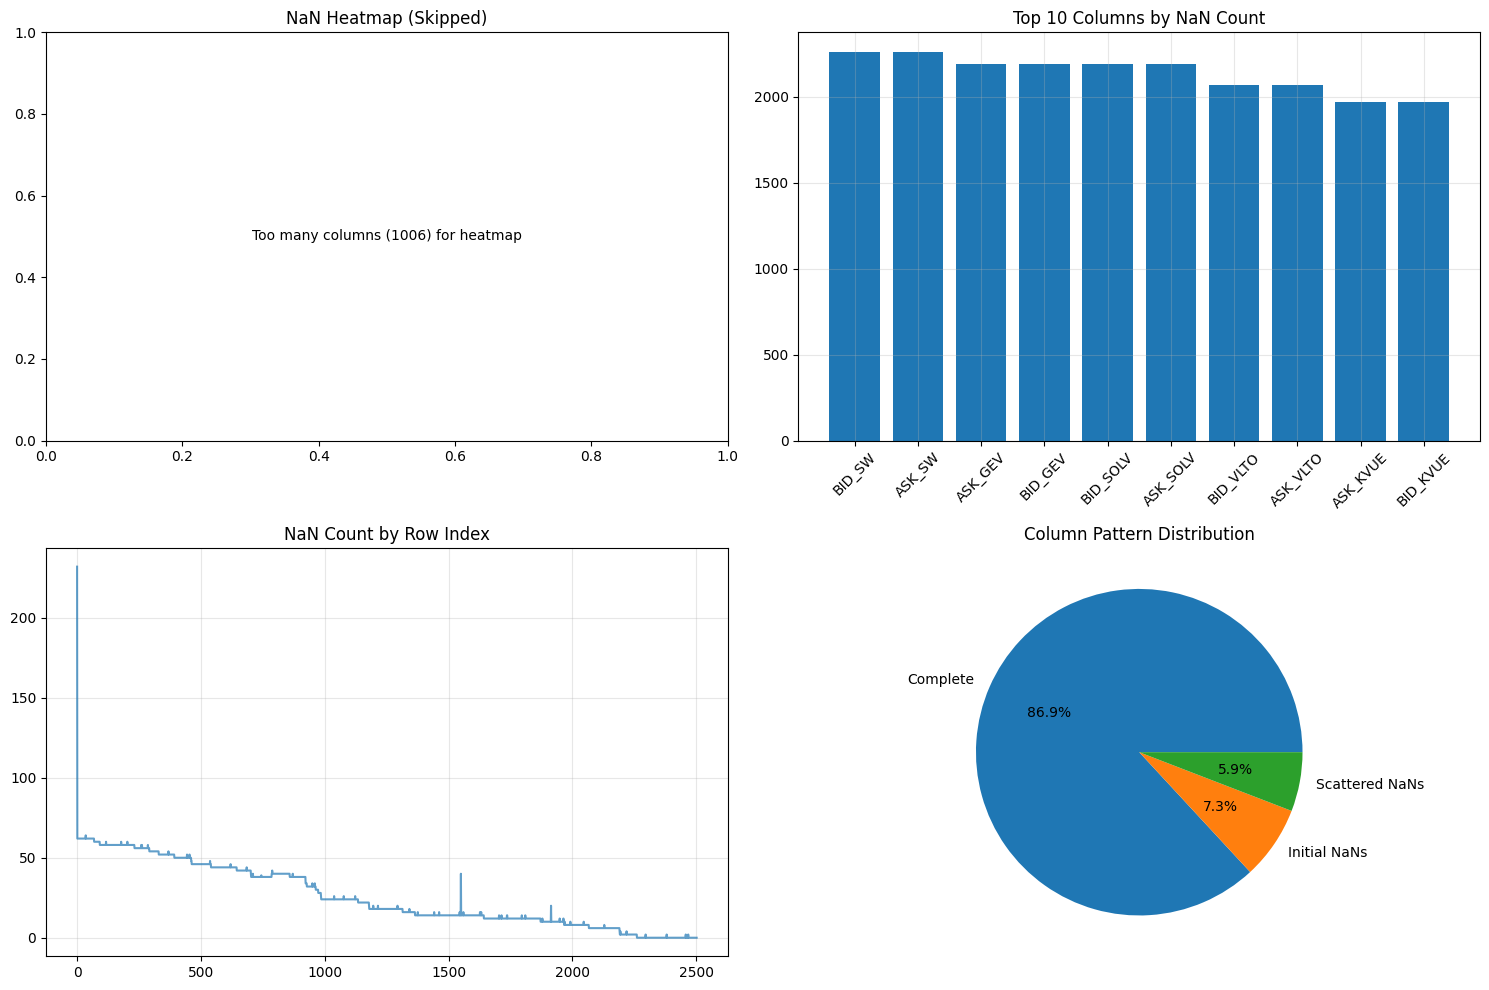


Function returned: ['total_nans', 'nan_percentage', 'columns_with_nans', 'rows_with_nans', 'patterns', 'worst_columns']


In [60]:
nan_summary = analyze_nan_patterns(bas, title="BAS DataFrame NaN Analysis", date_col="Date")
print(f"\nFunction returned: {list(nan_summary.keys())}")

BID-ASK SPREADS COMPREHENSIVE NAN ANALYSIS
Dataset Overview:
Shape: 2,503 rows × 1,006 columns
Total cells: 2,518,018
Total NaN values: 64,403
Overall NaN percentage: 2.558%

==================== COLUMN-WISE ANALYSIS ====================
Columns with NaN values: 264 (26.2%)
Columns without NaN values: 742 (73.8%)

Column NaN Statistics:
Mean NaNs per column: 64.0
Median NaNs per column: 0.0
Std NaNs per column: 293.1
Max NaNs in a column: 2,261 (90.3%)
Min NaNs in affected columns: 1

Top 15 worst columns for NaN values:
   1. BID_SW: 2,261 NaNs (90.3%)
   2. ASK_SW: 2,261 NaNs (90.3%)
   3. ASK_GEV: 2,192 NaNs (87.6%)
   4. BID_GEV: 2,192 NaNs (87.6%)
   5. BID_SOLV: 2,191 NaNs (87.5%)
   6. ASK_SOLV: 2,191 NaNs (87.5%)
   7. BID_VLTO: 2,067 NaNs (82.6%)
   8. ASK_VLTO: 2,067 NaNs (82.6%)
   9. ASK_KVUE: 1,967 NaNs (78.6%)
  10. BID_KVUE: 1,967 NaNs (78.6%)
  11. BID_GEHC: 1,872 NaNs (74.8%)
  12. ASK_GEHC: 1,872 NaNs (74.8%)
  13. ASK_CEG: 1,643 NaNs (65.6%)
  14. BID_CEG: 1,643 NaNs

/var/folders/7s/1b4ztzgn4fj7gc86hks6w5vc0000gn/T/ipykernel_63042/2816834094.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


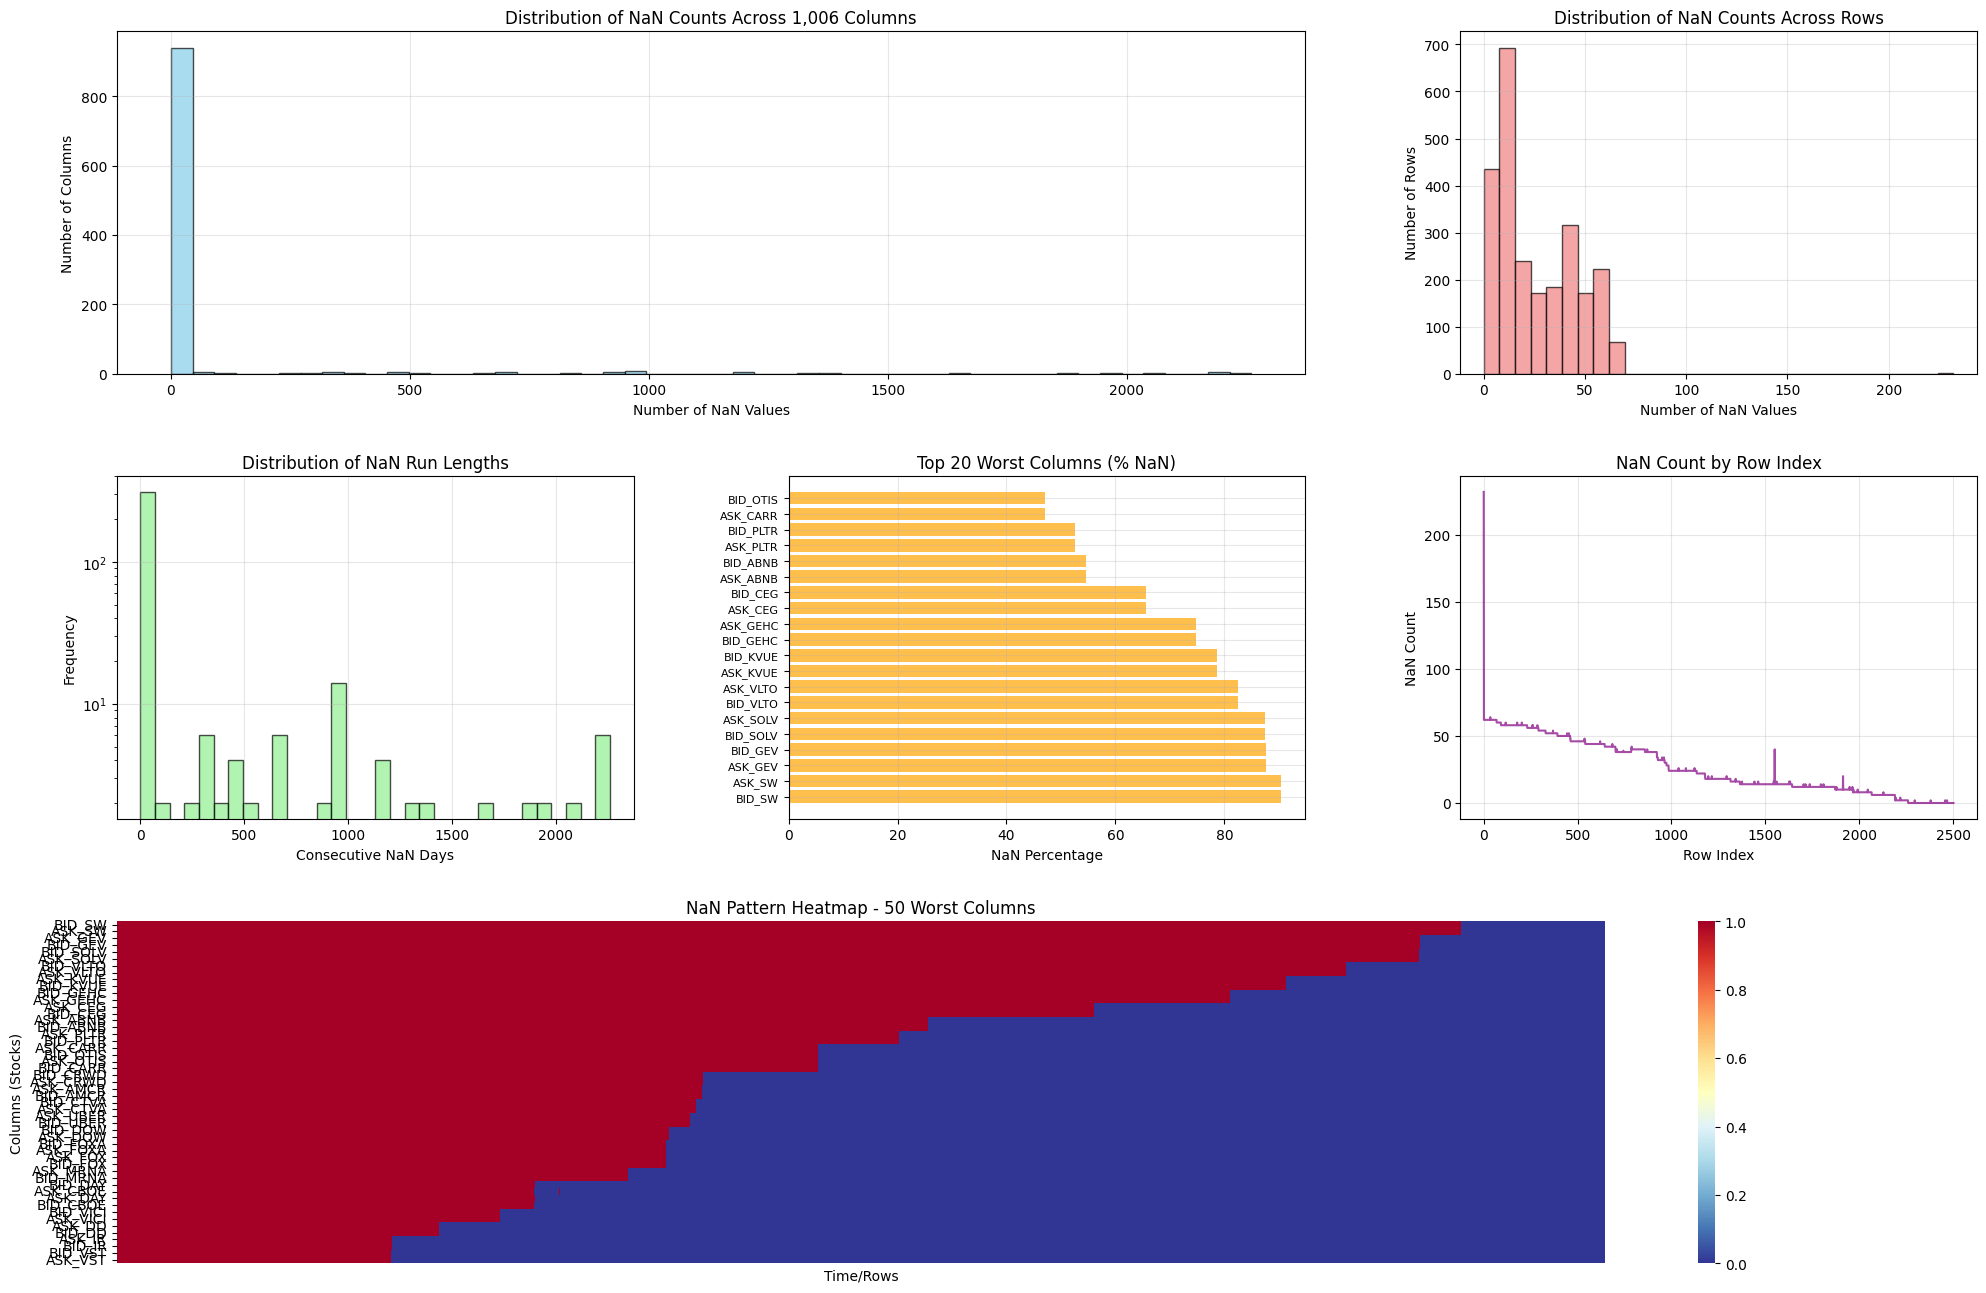


==================== SUMMARY STATISTICS ====================
✓ Analysis complete!
✓ Found 373 NaN runs across 264 columns
✓ Generated comprehensive visualizations

Function returned summary with keys: ['dataset_shape', 'total_cells', 'total_nans', 'overall_nan_percentage', 'columns_with_nans', 'columns_without_nans', 'rows_with_nans', 'rows_without_nans', 'column_stats', 'row_stats', 'run_length_stats', 'column_run_stats']

Example: Stocks with most NaN runs:
  BID_DFS: 44 separate NaN runs
  ASK_DFS: 44 separate NaN runs
  BID_BIIB: 2 separate NaN runs
  ASK_BIIB: 2 separate NaN runs
  ASK_CBOE: 2 separate NaN runs


In [81]:
# Test the comprehensive NaN analysis function with the bid-ask spreads data
comprehensive_summary = comprehensive_nan_analysis(
    bas, 
    title="BID-ASK SPREADS COMPREHENSIVE NaN ANALYSIS",
    date_col="Date",  # Assuming Date is your date column
    top_n_display=15  # Show top 15 worst items
)

print(f"\nFunction returned summary with keys: {list(comprehensive_summary.keys())}")

# You can access specific results like this:
if 'column_run_stats' in comprehensive_summary and comprehensive_summary['column_run_stats']:
    print(f"\nExample: Stocks with most NaN runs:")
    run_counts = {stock: stats['num_runs'] for stock, stats in comprehensive_summary['column_run_stats'].items()}
    top_run_stocks = sorted(run_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    for stock, num_runs in top_run_stocks:
        print(f"  {stock}: {num_runs} separate NaN runs")

In [ ]:
# number of columns that have nans
print(f"\nTotal number of columns with NaN values: {comprehensive_summary['columns_with_nans']}")


Total number of columns with NaN values: 264


In [93]:
# make bas data a datetime index in format YYYY-MM-DD
bas.index = pd.to_datetime(bas.index).strftime('%Y-%m-%d')

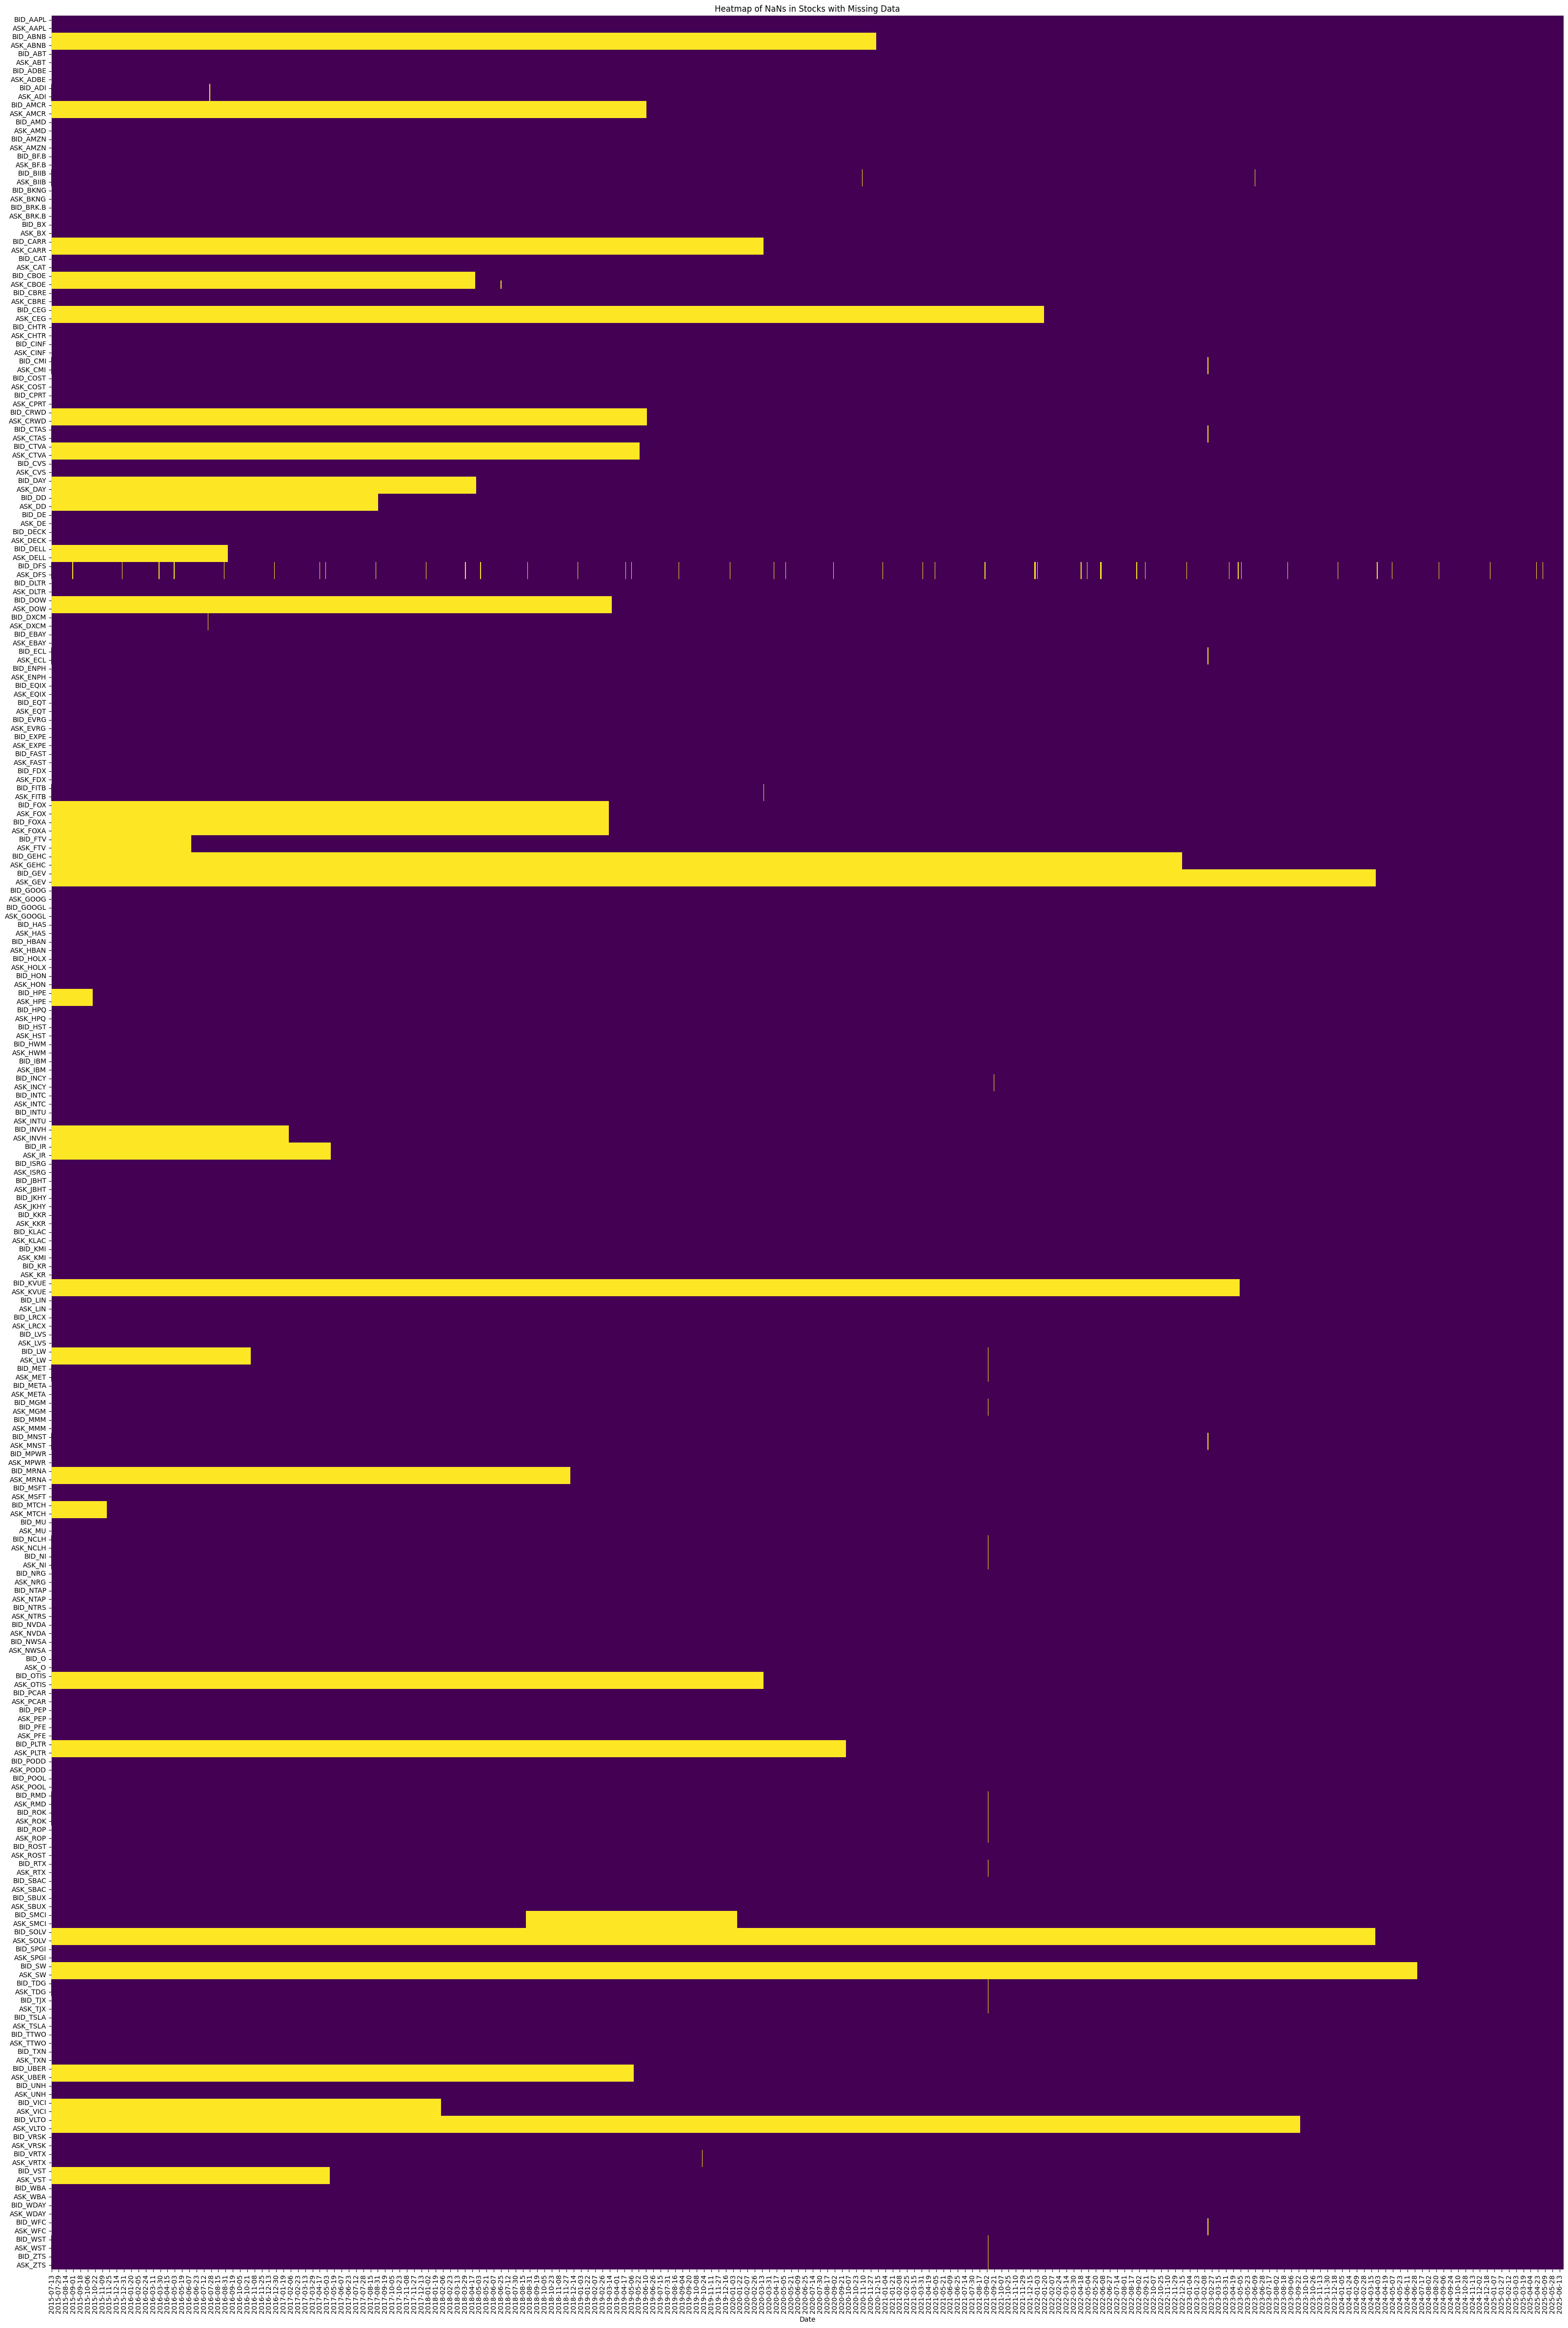

In [102]:
# heatmap of nans for the columns with NaNs
stocks_with_nans = [col for col, count in bas.isnull().sum().items() if count > 0]
dfnanstocksbas = bas[stocks_with_nans]

# let's put the rows as columns and columns as rows for the heatmap
plt.figure(figsize=(40, 60))
sns.heatmap(dfnanstocksbas.T.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of NaNs in Stocks with Missing Data')
plt.show()


In [106]:
# check how many nans ASK_AAPL and BID_AAPL have
print(f"Number of NaNs in ASK_AAPL: {bas['ASK_AAPL'].isnull().sum()}")
print(f"Number of NaNs in BID_AAPL: {bas['BID_AAPL'].isnull().sum()}")

Number of NaNs in ASK_AAPL: 1
Number of NaNs in BID_AAPL: 1


In [116]:
import eikon as ek

ek.set_app_key("898596c0c8884f6abd3faecd0d50522bf26c0242")

In [122]:
help(ek.get_symbology)

Help on function get_symbology in module eikon.symbology:

get_symbology(
    symbol,
    from_symbol_type='RIC',
    to_symbol_type=None,
    raw_output=False,
    debug=False,
    best_match=True
)
    Returns a list of instrument names converted into another instrument code.
    For example: convert SEDOL instrument names to RIC names

    Parameters
    ----------
    symbol: string or list of strings
        Single instrument or list of instruments to convert.

    from_symbol_type: string
        Instrument code to convert from.
        Possible values: 'CUSIP', 'ISIN', 'SEDOL', 'RIC', 'ticker', 'lipperID', 'IMO'
        Default: 'RIC'

    to_symbol_type: string or list
        Instrument code to convert to.
        Possible values: 'CUSIP', 'ISIN', 'SEDOL', 'RIC', 'ticker', 'lipperID', 'IMO', 'OAPermID'
        Default: None  (means all symbol types are requested)

    raw_output: boolean, optional
        Set this parameter to True to get the data in json format
        if set

In [140]:
pricedf = pd.read_csv('prices.csv', parse_dates=['Date'], index_col='Date')
all_stocks = pricedf.columns.tolist()
print(len(all_stocks), "stocks in the prices dataframe")
all_stocks

476 stocks in the prices dataframe


['A',
 'AAPL',
 'ABBV',
 'ABT',
 'ACGL',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALL',
 'ALLE',
 'AMAT',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'ANET',
 'ANSS',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'APO',
 'APTV',
 'ARE',
 'ATO',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXON',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BALL',
 'BAX',
 'BBY',
 'BDX',
 'BEN',
 'BF.A',
 'BF.B',
 'BG',
 'BIIB',
 'BK',
 'BKNG',
 'BLDR',
 'BLK',
 'BMY',
 'BR',
 'BRK.A',
 'BRK.B',
 'BRO',
 'BSX',
 'BWA',
 'BX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CAT',
 'CB',
 'CBOE',
 'CBRE',
 'CCI',
 'CCL',
 'CDNS',
 'CDW',
 'CE',
 'CF',
 'CFG',
 'CHD',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COO',
 'COP',
 'COR',
 'COST',
 'CPAY',
 'CPB',
 'CPRT',
 'CPT',
 'CRL',
 'CRM',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTRA',
 'CTSH',
 'CUK',
 'CVS',
 'CVX',
 'CZR',
 'D'

In [141]:
ric_df = ek.get_symbology(
    all_stocks, 
    from_symbol_type = "ticker", 
    to_symbol_type = "RIC",
    best_match=False
)

# use only the first element in the RICs column
ric_df['RICs'] = ric_df['RICs'].apply(lambda x: x[0] if isinstance(x, list) else x)   
ric_df = ric_df.drop(columns=['bestMatch'])
# set index to symbol 
ric_df.set_index('symbol', inplace=True)

print(ric_df.head())


          RICs
symbol        
A            A
AAPL    AAPL.O
ABBV    ABBV.K
ABT        ABT
ACGL    ACGL.O


In [146]:
riclist = ric_df['RICs'].to_list()
riclist

['A',
 'AAPL.O',
 'ABBV.K',
 'ABT',
 'ACGL.O',
 'ACN',
 'ADBE.O',
 'ADI.O',
 'ADM',
 'ADP.O',
 'ADSK.O',
 'AEE',
 'AEP.O',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM.O',
 'ALB',
 'ALGN.O',
 'ALL',
 'ALLE.K',
 'AMAT.O',
 'AMD.O',
 'AME',
 'AMGN.O',
 'AMP',
 'AMT',
 'AMZN.O',
 'ANET.K',
 'ANSS.O',
 'AON',
 'AOS',
 'APA.O',
 'APD',
 'APH',
 'APO',
 'APTV.K',
 'ARE',
 'ATO',
 'AVB',
 'AVGO.O',
 'AVY',
 'AWK',
 'AXON.O',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BALL.K',
 'BAX',
 'BBY',
 'BDX',
 'BEN',
 'BFa',
 'BFb',
 'BG',
 'BIIB.O',
 'BK',
 'BKNG.O',
 'BLDR.K',
 'BLK',
 'BMY',
 'BR',
 'BRKa',
 'BRKb',
 'BRO',
 'BSX',
 'BWA',
 'BX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CAT',
 'CB',
 'CBOE.K',
 'CBRE.K',
 'CCI',
 'CCL',
 'CDNS.O',
 'CDW.O',
 'CE',
 'CF',
 'CFG',
 'CHD',
 'CHRW.O',
 'CHTR.O',
 'CI',
 'CINF.O',
 'CL',
 'CLX',
 'CMCSA.O',
 'CME.O',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COO.O',
 'COP',
 'COR',
 'COST.O',
 'CPAY.K',
 'CPB.O',
 'CPRT.O',
 'CPT',
 'CRL',
 'CRM',
 'CSCO.O',
 'CS

In [149]:
# 3. Helper to chunk into batches of size n
def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i : i + n]

# 4. Fields and params stay the same
fields = ["TR.BIDPRICE.Date", "TR.BIDPRICE", "TR.ASKPRICE"]
params = {
    "SDate": "2015-07-13",
    "EDate": "2025-06-24",
    "Frq":   "D"
}

# 5. Loop through in batches of 50, fetch and clean each
batches = []
for batch in chunk_list(riclist, 50):
    df_batch, err = ek.get_data(batch, fields, params)
    if err:
        print(f"Warning on batch starting with {batch[0]}: {err}")
    # rename for convenience
    df_batch.rename(columns={
        "TR.BIDPRICE.Date": "Date",
        "TR.BIDPRICE":      "BidPrice",
        "TR.ASKPRICE":      "AskPrice"
    }, inplace=True)
    # format Date as YYYY-MM-DD
    df_batch["Date"] = pd.to_datetime(df_batch["Date"]).dt.strftime("%Y-%m-%d")
    batches.append(df_batch)

# 6. Concatenate all batches
baseikon = pd.concat(batches, ignore_index=True)

# 7. Set Date as index
baseikon.set_index("Date", inplace=True)

print(baseikon.head())


/Users/ranystephan/Library/Mobile Documents/com~apple~CloudDocs/Desktop/convex_optimization_research/cvxtransformation/venv/lib/python3.13/site-packages/eikon/data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/ranystephan/Library/Mobile Documents/com~apple~CloudDocs/Desktop/convex_optimization_research/cvxtransformation/venv/lib/python3.13/site-packages/eikon/data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/ranystephan/Library/Mobile Documents/com~apple~CloudDocs/Desktop/convex_optimization_research/cvxtransformation/venv/lib/python3.13/site-packages/eikon/data_grid.py:255: FutureWarning: errors='ignore' is deprecated and wi

           Instrument  Bid Price  Ask Price
Date                                       
2015-07-13          A      39.95      39.96
2015-07-14          A      40.49       40.5
2015-07-15          A      40.12      40.13
2015-07-16          A      40.34      40.35
2015-07-17          A      39.94      39.95


/Users/ranystephan/Library/Mobile Documents/com~apple~CloudDocs/Desktop/convex_optimization_research/cvxtransformation/venv/lib/python3.13/site-packages/eikon/data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [168]:
ric_df

,RICs
symbol,
A,A
AAPL,AAPL.O
ABBV,ABBV.K
ABT,ABT
ACGL,ACGL.O
...,...
XYL,XYL
YUM,YUM
ZBH,ZBH


In [173]:
# use ric_df to convert instrument names from RIC to ticker. Every RIC in baseikon should have a corresponding ticker in ric_df as the index called 'symbol'

ric_to_symbol = { ric: sym for sym, ric in ric_df['RICs'].items() }

baseikon['Instrument'] = baseikon['Instrument'].map(ric_to_symbol)

missing = baseikon['Instrument'].isna().sum() 
if missing:
    print(f"Warning: {missing} instruments could not be mapped to tickers.")

baseikon

,Instrument,Bid Price,Ask Price
Date,,,
2015-07-13,A,39.95,39.96
2015-07-14,A,40.49,40.5
2015-07-15,A,40.12,40.13
2015-07-16,A,40.34,40.35
2015-07-17,A,39.94,39.95
...,...,...,...
2025-06-17,ZTS,161.57,161.58
2025-06-18,ZTS,155.13,155.19
2025-06-20,ZTS,157.17,157.28


In [175]:
# make spread column be (Ask Price - Bid Price) / ((Ask Price + Bid Price) / 2)
baseikon['Spread'] = (baseikon['Ask Price'] - baseikon['Bid Price']) / ((baseikon['Ask Price'] + baseikon['Bid Price']) / 2)
baseikon

,Instrument,Bid Price,Ask Price,Spread
Date,,,,
2015-07-13,A,39.95,39.96,0.00025
2015-07-14,A,40.49,40.5,0.000247
2015-07-15,A,40.12,40.13,0.000249
2015-07-16,A,40.34,40.35,0.000248
2015-07-17,A,39.94,39.95,0.00025
...,...,...,...,...
2025-06-17,ZTS,161.57,161.58,0.000062
2025-06-18,ZTS,155.13,155.19,0.000387
2025-06-20,ZTS,157.17,157.28,0.0007


In [176]:
baseikon.drop(columns=['Bid Price', 'Ask Price'], inplace=True)
baseikon

,Instrument,Spread
Date,,
2015-07-13,A,0.00025
2015-07-14,A,0.000247
2015-07-15,A,0.000249
2015-07-16,A,0.000248
2015-07-17,A,0.00025
...,...,...
2025-06-17,ZTS,0.000062
2025-06-18,ZTS,0.000387
2025-06-20,ZTS,0.0007


In [191]:
baseikon

,Date,Instrument,Spread
0,2015-07-13,A,0.00025
1,2015-07-14,A,0.000247
2,2015-07-15,A,0.000249
3,2015-07-16,A,0.000248
4,2015-07-17,A,0.00025
...,...,...,...
1189015,2025-06-17,ZTS,0.000062
1189016,2025-06-18,ZTS,0.000387
1189017,2025-06-20,ZTS,0.0007
1189018,2025-06-23,ZTS,0.000318


In [197]:
spread_df = baseikon.pivot(index='Date', columns='Instrument', values='Spread')
spread_df.columns.name = None
spread_df

,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-13,0.00025,0.00008,0.000144,0.000201,0.000145,0.000099,0.000246,0.000323,0.000211,0.000245,...,0.000213,0.000316,0.000093,0.000298,0.000121,0.000277,0.00011,0.000093,0.000453,0.000213
2015-07-14,0.000247,0.00008,0.000143,0.000199,0.000579,0.000099,0.000244,0.000319,0.000209,0.000122,...,0.000213,0.00032,0.000093,0.000298,0.00012,0.000274,0.000326,0.000186,0.000088,0.000211
2015-07-15,0.000249,0.000158,0.000143,0.000203,0.00029,0.0001,0.000365,0.000318,0.000211,0.000121,...,0.000213,0.00032,0.000097,0.000297,0.000121,0.000278,0.000225,0.00028,0.000268,0.000212
2015-07-16,0.000248,0.000078,0.000143,0.000201,0.000144,0.000099,0.000121,0.000318,0.000209,0.000121,...,0.000213,0.000323,0.000289,0.000293,0.000121,0.000278,0.000113,0.000278,0.000526,0.000208
2015-07-17,0.00025,0.000077,0.000143,0.0002,0.000577,0.0001,0.000487,0.00016,0.000208,0.000364,...,0.000213,0.000328,0.000098,0.000297,0.000121,0.000279,0.000114,0.000093,0.000175,0.000209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,0.000086,0.000307,0.000216,0.000151,0.000111,0.000032,0.000052,0.000615,0.00037,0.000228,...,0.000604,0.000386,0.000344,0.000305,0.000088,0.00008,0.000071,0.000111,0.000449,0.000062
2025-06-18,0.000087,0.000102,0.000054,0.000076,0.000222,0.000033,0.000423,0.000305,0.000185,0.000489,...,0.000336,0.000385,0.00046,0.000453,0.000088,0.00032,0.000072,0.00011,0.000994,0.000387
2025-06-20,0.00026,0.00005,0.000108,0.000075,0.000111,0.000491,0.000053,0.00035,0.000187,0.00062,...,0.000903,0.000382,0.000226,0.00015,0.000087,0.00008,0.000072,0.00011,0.001088,0.0007


In [230]:
# check if the dates are the same in spread_df and pricesdf
spread_dates = set(spread_df.index)
prices_dates = set(pricedf.index)
common_dates = spread_dates.intersection(prices_dates)
print(f"Number of common dates: {len(common_dates)}")
print(f"Number of dates in spread_df: {len(spread_dates)}")
print(f"Number of dates in pricesdf: {len(prices_dates)}")

Number of common dates: 2503
Number of dates in spread_df: 2534
Number of dates in pricesdf: 2503


In [232]:
# list dates that are in spread_df but not in pricesdf
spread_only_dates = spread_dates.difference(prices_dates)
print(f"Number of dates in spread_df but not in pricesdf: {len(spread_only_dates)}")
print("First few dates in spread_df but not in pricesdf:")
print(list(spread_only_dates)[:50])

Number of dates in spread_df but not in pricesdf: 31
First few dates in spread_df but not in pricesdf:
['2015-12-25', '2015-11-26', '2017-11-23', '2016-12-26', '2018-12-05', '2018-07-04', '2018-01-15', '2017-04-14', '2018-05-28', '2015-09-07', '2016-11-24', '2017-01-02', '2016-07-04', '2017-05-29', '2017-02-20', '2025-01-09', '2016-01-01', '2016-09-05', '2017-07-04', '2018-01-01', '2016-01-18', '2023-04-07', '2018-02-19', '2016-03-25', '2017-01-16', '2018-03-30', '2021-04-02', '2017-09-04', '2016-05-30', '2016-02-15', '2017-12-25']


In [238]:
# use the intersection dates to on spread_df
spread_df = spread_df.loc[list(common_dates)]
spread_df.to_csv('spreads.csv', index=True)


BID-ASK SPREADS NAN PATTERN ANALYSIS
Dataset Overview:
Shape: 2,503 rows × 475 columns
Total cells: 1,188,925
Total NaN values: 1,895
Overall NaN percentage: 0.159%

==================== COLUMN-WISE ANALYSIS ====================
Columns with NaN values: 125 (26.3%)
Columns without NaN values: 350 (73.7%)

Column NaN Statistics:
Mean NaNs per column: 4.0
Median NaNs per column: 0.0
Std NaNs per column: 46.7
Max NaNs in a column: 787 (31.4%)
Min NaNs in affected columns: 1

Top 15 worst columns for NaN values:
   1. ES: 787 NaNs (31.4%)
   2. DD: 541 NaNs (21.6%)
   3. SMCI: 349 NaNs (13.9%)
   4. MTCH: 92 NaNs (3.7%)
   5. MHK: 2 NaNs (0.1%)
   6. BIIB: 2 NaNs (0.1%)
   7. MTD: 2 NaNs (0.1%)
   8. MSCI: 2 NaNs (0.1%)
   9. WEC: 2 NaNs (0.1%)
  10. TMO: 1 NaNs (0.0%)
  11. TFX: 1 NaNs (0.0%)
  12. TGT: 1 NaNs (0.0%)
  13. TJX: 1 NaNs (0.0%)
  14. ADI: 1 NaNs (0.0%)
  15. TPL: 1 NaNs (0.0%)

==================== ROW-WISE ANALYSIS ======================
Rows with NaN values: 1,141 (45.6%)


/var/folders/7s/1b4ztzgn4fj7gc86hks6w5vc0000gn/T/ipykernel_63042/2816834094.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


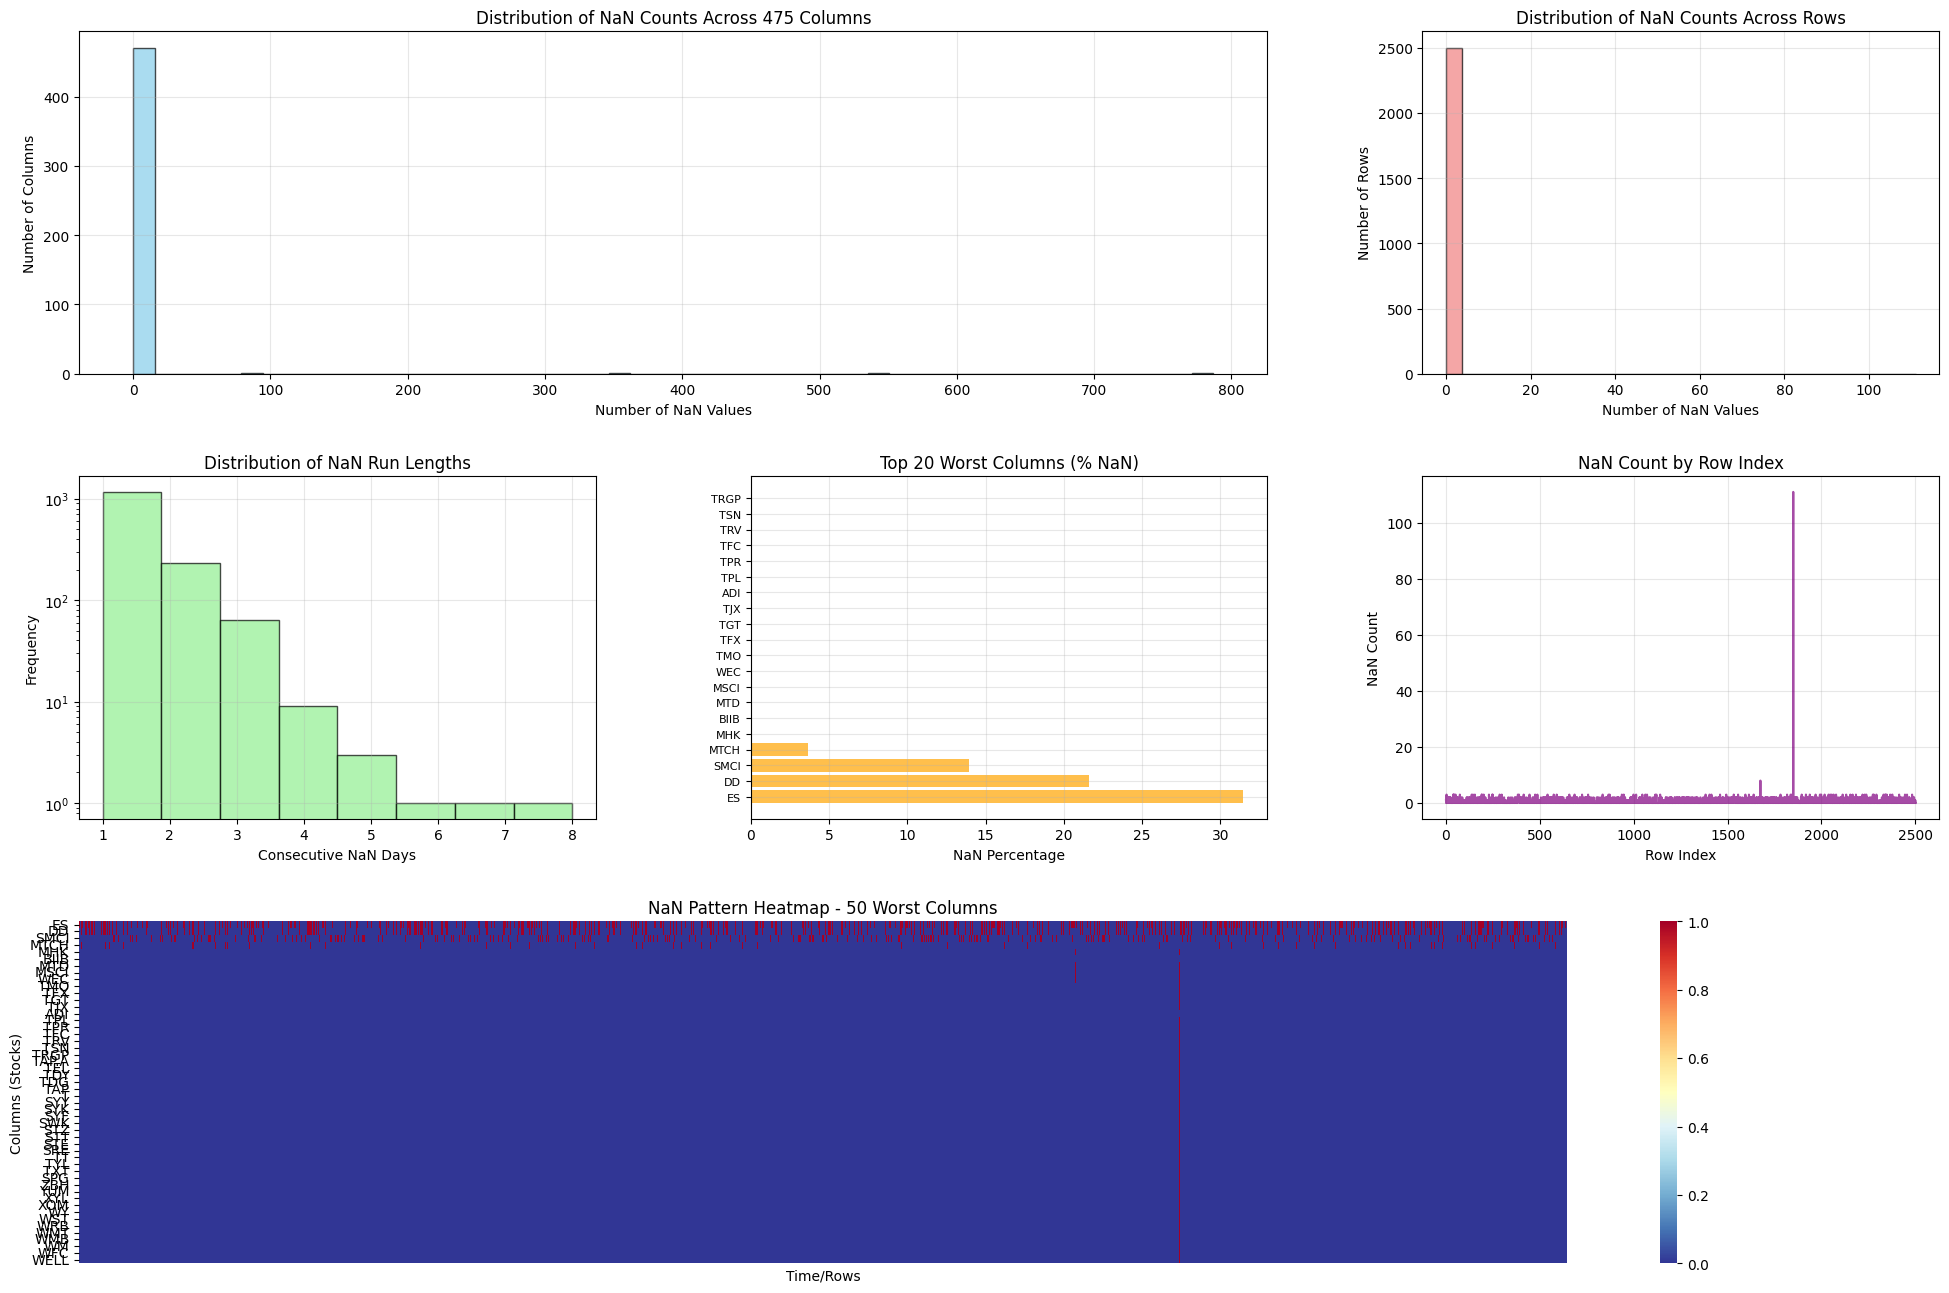


==================== SUMMARY STATISTICS ====================
✓ Analysis complete!
✓ Found 1,478 NaN runs across 125 columns
✓ Generated comprehensive visualizations

Function returned summary with keys: ['dataset_shape', 'total_cells', 'total_nans', 'overall_nan_percentage', 'columns_with_nans', 'columns_without_nans', 'rows_with_nans', 'rows_without_nans', 'column_stats', 'row_stats', 'run_length_stats', 'column_run_stats']


In [243]:
comprehensive_nan_analysis(spread_df, title="Bid-Ask Spreads NaN Pattern Analysis",
                          date_col="Date", top_n_display=15)

print(f"\nFunction returned summary with keys: {list(comprehensive_summary.keys())}")


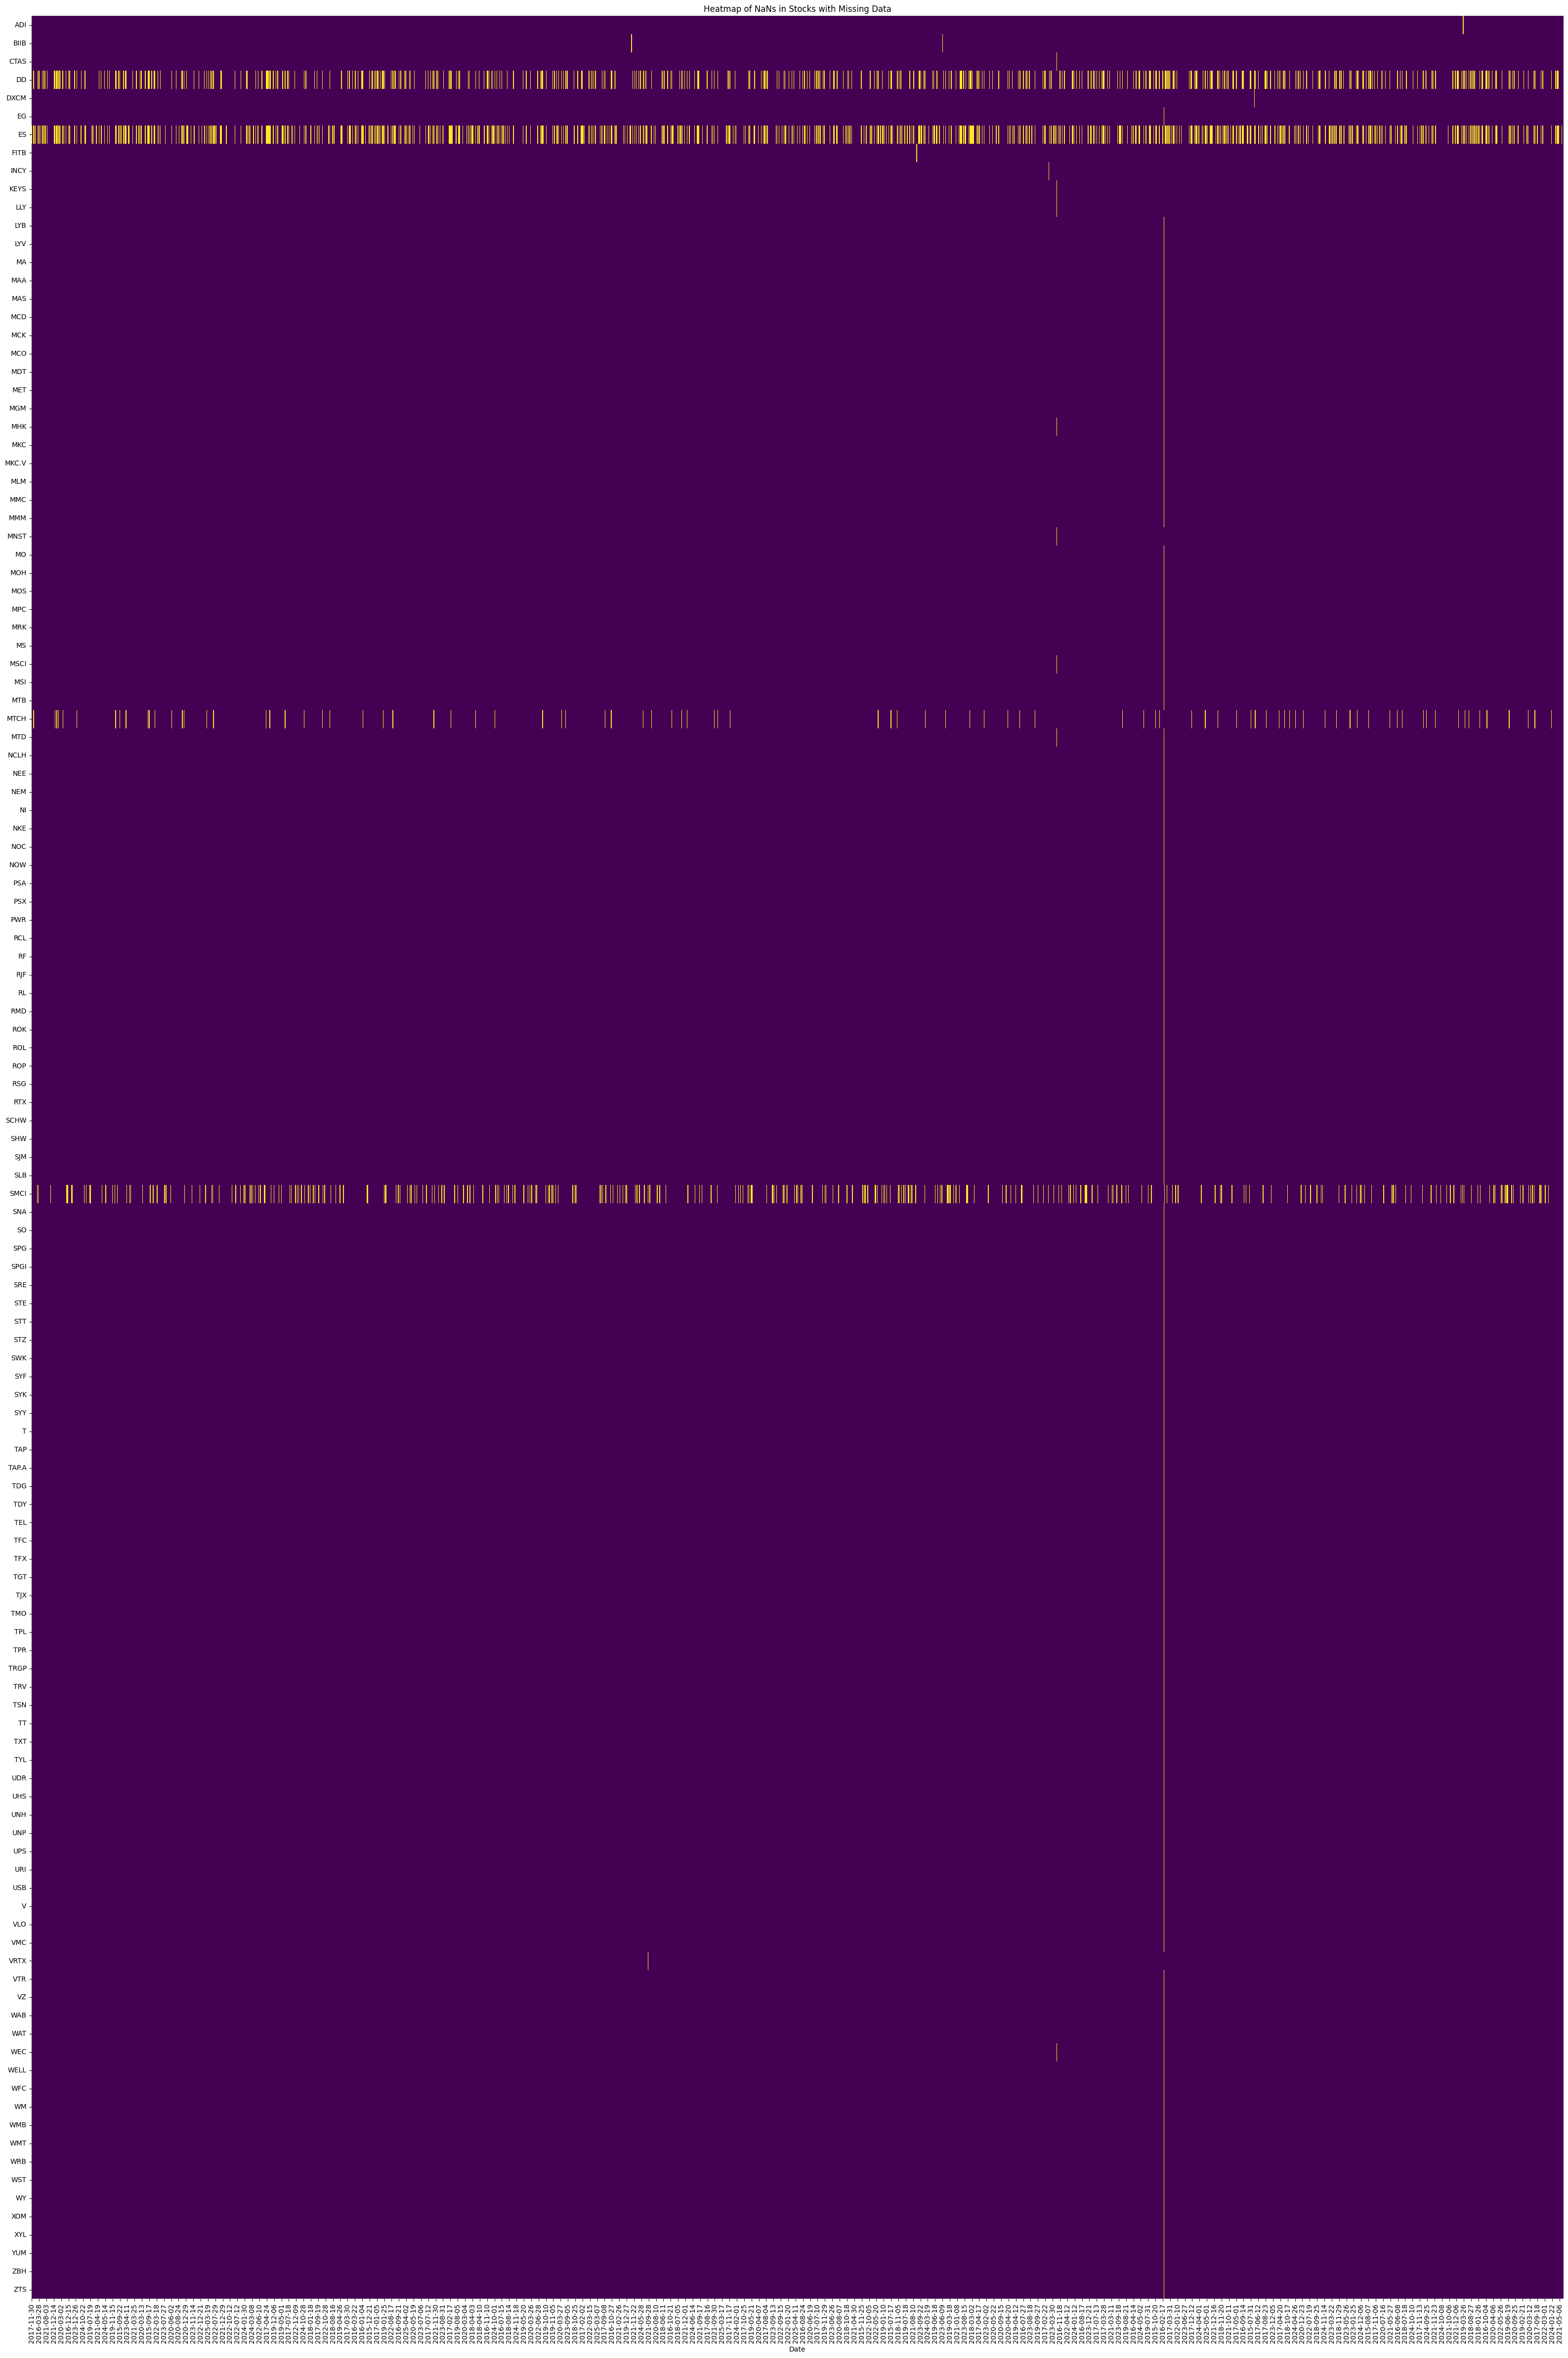

In [240]:
# heatmap of nans for the columns with NaNs
stocks_with_nans = [col for col, count in spread_df.isnull().sum().items() if count > 0]
dfnanstocksspreads = spread_df[stocks_with_nans]

# let's put the rows as columns and columns as rows for the heatmap
plt.figure(figsize=(40, 60))
sns.heatmap(dfnanstocksspreads.T.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of NaNs in Stocks with Missing Data')
plt.show()


In [241]:
# check data of pricedf and spread_df on 2016-02-17, anc check how many nans in each
date_to_check = '2016-02-17'
print(f"Data on {date_to_check} in pricesdf:")
print(pricedf.loc[date_to_check])
print(f"Number of NaNs in pricesdf on {date_to_check}: {pricedf.loc[date_to_check].isnull().sum()}")
print(f"\nData on {date_to_check} in spread_df:")
print(spread_df.loc[date_to_check])
print(f"Number of NaNs in spread_df on {date_to_check}: {spread_df.loc[date_to_check].isnull().sum()}")

Data on 2016-02-17 in pricesdf:
A        37.87
AAPL    392.48
ABBV     55.01
ABT      38.45
ACGL    204.57
         ...  
XYL      37.66
YUM      71.20
ZBH      95.37
ZBRA     67.05
ZTS      41.80
Name: 2016-02-17, Length: 475, dtype: float64
Number of NaNs in pricesdf on 2016-02-17: 0

Data on 2016-02-17 in spread_df:
A       0.000264
AAPL    0.000102
ABBV    0.000364
ABT      0.00026
ACGL     0.00044
          ...   
XYL     0.000266
YUM      0.00014
ZBH      0.00021
ZBRA    0.000448
ZTS     0.000239
Name: 2016-02-17, Length: 475, dtype: Float64
Number of NaNs in spread_df on 2016-02-17: 2


In [244]:
# date with most NaNs in spread_df
most_nans_date = spread_df.isnull().sum().idxmax()
most_nans_count = spread_df.isnull().sum().max()
print(f"\nDate with most NaNs in spread_df: {most_nans_date}")
print(f"Number of NaNs on {most_nans_date}: {most_nans_count}")


Date with most NaNs in spread_df: ES
Number of NaNs on ES: 787


In [269]:
# try to fetch data for ES again
# 3. Helper to chunk into batches of size n
def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i : i + n]

# 4. Fields and params stay the same
fields = ["TR.BIDPRICE.Date", "TR.BIDPRICE", "TR.ASKPRICE"]
params = {
    "SDate": "2015-07-13",
    "EDate": "2025-06-24",
    "Frq":   "D"
}

es_data, es_error = ek.get_data(  ['ES'], 
    fields,
    params
)

es_data

/Users/ranystephan/Library/Mobile Documents/com~apple~CloudDocs/Desktop/convex_optimization_research/cvxtransformation/venv/lib/python3.13/site-packages/eikon/data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,Instrument,Date,Bid Price,Ask Price
0,ES,2015-07-13T00:00:00Z,47.04,47.05
1,ES,2015-07-14T00:00:00Z,47.29,47.3
2,ES,2015-07-15T00:00:00Z,47.74,47.75
3,ES,2015-07-16T00:00:00Z,48.31,48.32
4,ES,2015-07-17T00:00:00Z,47.91,47.92
...,...,...,...,...
2498,ES,2025-06-17T00:00:00Z,63.2,63.23
2499,ES,2025-06-18T00:00:00Z,62.41,62.42
2500,ES,2025-06-20T00:00:00Z,62.51,62.52
2501,ES,2025-06-23T00:00:00Z,63.36,63.37


In [270]:
es_data.isnull().sum()

Instrument    0
Date          0
Bid Price     0
Ask Price     0
dtype: int64

In [252]:
# how many stocks have nans in the spread_df
nans_in_spread_df = spread_df.isnull().sum()
stocks_with_nans_in_spread = nans_in_spread_df[nans_in_spread_df > 0]
print(f"Number of stocks with NaNs in spread_df: {len(stocks_with_nans_in_spread)}")
print("Stocks with NaNs in spread_df:")
print(stocks_with_nans_in_spread)

Number of stocks with NaNs in spread_df: 125
Stocks with NaNs in spread_df:
ADI       1
BIIB      2
CTAS      1
DD      541
DXCM      1
       ... 
XOM       1
XYL       1
YUM       1
ZBH       1
ZTS       1
Length: 125, dtype: int64


In [260]:
# look for AAPL row of spreads_df
spread_df['DD'].isnull().sum()

np.int64(541)

In [266]:
# look for DD row of ric_df
aapl_ric = ric_df.loc['DD', 'RICs']
print(f"DD RIC: {aapl_ric}")

DD RIC: DD
